In [ ]:
# ECSE 551 - MP2  
# Aymen Boustani 260916311 Hamza Chikhaoui 260912960

# We start by installing the some of the packages that are not by default on Google Colab

%pip install nltk
%pip install langdetect
%pip install spacy

In [ ]:
# More specific packages to download...

!python3 -m spacy download en_core_web_sm
!python3 -m spacy download fr_core_news_sm

In [287]:
# Importing the mandatory modules...

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import importlib
import nltk
import string
import time
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import text
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import BaggingClassifier
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from langdetect import detect
from naivebayes import NaiveBayes
from textprocessor import TextProcessor
from itertools import product
from crossvalidationmp2 import CrossValidation

In [23]:
# Last packages to download...

import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aymenboustani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/aymenboustani/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/aymenboustani/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [187]:
# We start by importing the CSV files as Pandas DataFrame and shuffle them using the sample() function

train_corpus = pd.read_csv('train.csv', encoding = 'cp1252' ).sample(frac = 1)
test_corpus = pd.read_csv('test.csv', encoding = 'cp1252' ).sample(frac = 1)
max_features = 3000

In [188]:
# Overview of the training corpus

train_corpus

,body,subreddit
353,# Upvote/Downvote reminder\n\nLike this image ...,London
462,"Il y'a quelques années, avenue Charles de Gaul...",Paris
65,"We tried to see the exhibits, except many had ...",Toronto
142,What is the speed limit there? That street lo...,Toronto
467,"Le 11e, limite 12e (vers Faidherbe-Reuilly). J...",Paris
...,...,...
593,A lot of established massage therapists don't ...,Montreal
387,Probablement un avion d'Aero Sotravia qui fait...,Paris
568,Since paying the membership fee doesn't guaran...,Montreal
656,Its the reasonable doubt standard: The judge h...,Montreal


In [190]:
#Initializes a column with numbers corresponding to each subreddit

train_corpus['labels'], unique_categories = pd.factorize(train_corpus['subreddit'])
train_corpus

,body,subreddit,labels
353,# Upvote/Downvote reminder\n\nLike this image ...,London,0
462,"Il y'a quelques années, avenue Charles de Gaul...",Paris,1
65,"We tried to see the exhibits, except many had ...",Toronto,2
142,What is the speed limit there? That street lo...,Toronto,2
467,"Le 11e, limite 12e (vers Faidherbe-Reuilly). J...",Paris,1
...,...,...,...
593,A lot of established massage therapists don't ...,Montreal,3
387,Probablement un avion d'Aero Sotravia qui fait...,Paris,1
568,Since paying the membership fee doesn't guaran...,Montreal,3
656,Its the reasonable doubt standard: The judge h...,Montreal,3


In [298]:
unique_categories

Index(['London', 'Paris', 'Toronto', 'Montreal'], dtype='object')

In [30]:
# Initializes the Tokenizers that will be used

class LemmaTokenizer:
    def __init__(self):
        self.nlp_en = spacy.load('en_core_web_sm')
        self.nlp_fr = spacy.load('fr_core_news_sm')
        self.wnl = WordNetLemmatizer()

    def __call__(self, doc):
        return self.lemmatize(doc)
    
    def __str__(self):
        return "Lemma Tokenizer"

    def detect_language(self, text):
        try:
            lang = detect(text)
            return lang
        except Exception as e:
            return None

    def lemmatize(self, text):
        lang = self.detect_language(text)
        if lang == 'fr':
            return [token.lemma_ for token in self.nlp_fr(text) if token.text.isalpha()]
        else:
            return [self.wnl.lemmatize(t, pos="v") for t in word_tokenize(text) if t.isalpha()]

class TFIDFVectorizer:
    def __init__(self, documents):
        self.documents = documents
        self.vectorizer = TfidfVectorizer()
        self.tfidf_matrix = self.vectorizer.fit_transform(documents)

    def __call__(self, query):
        query_tfidf = self.vectorizer.transform([query])
        feature_names = self.vectorizer.get_feature_names_out()
        tfidf_scores = []
        for col in query_tfidf.nonzero()[1]:
            term = feature_names[col]
            score = query_tfidf[0, col]
            tfidf_scores.append((term, score))
        tfidf_scores.sort(key=lambda x: x[1], reverse=True)
        return tfidf_scores

class StemTokenizer:
    def __init__(self):
        self.wnl_en = PorterStemmer()
        self.wnl_fr = SnowballStemmer('french')

    def __call__(self, doc):
        return self.stem(doc)
    
    def __str__(self):
        return "Stemming Tokenizer"

    def detect_language(self, text):
        try:
            lang = detect(text)
            return lang
        except Exception as e:
            return None

    def stem(self, text):
        lang = self.detect_language(text)
        if lang == 'fr':
            return [self.wnl_fr.stem(t) for t in word_tokenize(text) if t.isalpha()]
        else:
            return [self.wnl_en.stem(t) for t in word_tokenize(text) if t.isalpha()]

In [191]:
# Initializes the Y_train array contained the actual labels

Y_train = train_corpus['labels'].to_numpy()
Y_train

array([0, 1, 2, 2, 1, 3, 1, 0, 2, 3, 3, 1, 0, 0, 0, 2, 3, 2, 3, 3, 0, 0,
       3, 1, 2, 1, 0, 2, 1, 3, 1, 2, 3, 1, 3, 3, 3, 3, 2, 0, 2, 3, 2, 2,
       0, 2, 3, 0, 1, 2, 0, 1, 0, 2, 0, 3, 0, 2, 1, 0, 1, 3, 2, 0, 2, 3,
       0, 0, 0, 0, 2, 0, 1, 1, 3, 3, 3, 0, 1, 3, 0, 0, 3, 0, 1, 0, 0, 0,
       3, 2, 0, 2, 1, 2, 2, 1, 2, 0, 3, 2, 1, 0, 2, 3, 0, 3, 0, 2, 1, 2,
       1, 1, 1, 2, 0, 2, 3, 3, 3, 2, 0, 2, 0, 2, 0, 2, 3, 1, 2, 2, 3, 0,
       3, 3, 2, 0, 0, 2, 1, 1, 1, 2, 2, 0, 1, 3, 0, 1, 3, 3, 3, 0, 1, 0,
       0, 3, 0, 2, 3, 0, 1, 0, 0, 2, 1, 1, 1, 1, 0, 3, 0, 1, 1, 3, 2, 3,
       0, 3, 3, 3, 1, 2, 2, 0, 2, 0, 2, 1, 0, 1, 1, 1, 2, 1, 2, 2, 3, 2,
       0, 2, 2, 1, 3, 3, 1, 0, 1, 2, 0, 2, 0, 3, 2, 1, 1, 2, 2, 1, 1, 0,
       1, 0, 2, 3, 2, 3, 1, 2, 1, 3, 3, 0, 1, 0, 3, 1, 3, 0, 2, 2, 0, 1,
       0, 2, 1, 0, 1, 0, 0, 2, 2, 2, 3, 2, 2, 1, 2, 0, 0, 2, 2, 1, 3, 3,
       3, 0, 2, 0, 2, 2, 1, 3, 3, 1, 2, 2, 2, 0, 0, 3, 3, 0, 2, 1, 3, 1,
       3, 1, 2, 0, 1, 1, 2, 0, 1, 2, 2, 3, 0, 1, 1,

In [31]:
# 10 folds Cross Validation on BNB:
tfidf = normalization = smooth = [True, False]
features, tokens = np.linspace(1000, 3000, 5, dtype = int), [None, LemmaTokenizer(), StemTokenizer()]
accuracies, count, execution = {}, 1, {}
for t in tfidf:
    for normal in normalization:
        for s in smooth:
            for n in features:
                for token in tokens:
                    start = time.time()
                    label = f'TF - IDF = {t} | Normalization = {normal} | Laplace Smoothing = {s} | Number of features = {n} | Tokenizer = {token}'
                    processor = TextProcessor(True, True, t, token, normal, n)
                    X = processor.trainX(train_corpus)
                    model, validation = NaiveBayes(s), CrossValidation(10)
                    accuracies[label] = validation.validate(model, X, Y_train, False, unique_categories, False)
                    end = time.time()
                    step = end - start
                    execution[label] = step
                    print(f'Iteration {count} out of 120 with TF - IDF = {t} | Normalization = {normal} | Laplace Smoothing = {s} | Number of features = {n} | Tokenizer = {token}')
                    print(f'Iteration {count} was {step} s long')
                    count += 1

Averrage accuracy of Naive Bayes is : 24.62 %
Iteration 1 out of 120 with TF - IDF = True | Normalization = True | Laplace Smoothing = True | Number of features = 1000 | Tokenizer = None
Iteration 1 was 11.058075904846191 s long
Averrage accuracy of Naive Bayes is : 24.47 %
Iteration 2 out of 120 with TF - IDF = True | Normalization = True | Laplace Smoothing = True | Number of features = 1000 | Tokenizer = Lemma Tokenizer
Iteration 2 was 16.953678846359253 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'aur', 'aurion', 'auron', 'avai', 'avion', 'avon', 'ayon', 'becaus', 'befor', 'could', 'dan', 'doe', 'dure', 'e', 'ell', 'euss', 'eussion', 'eûm', 'fuss', 'fussion', 'fûm', 'ha', 'hi', 'mai', 'might', 'must', 'mêm', 'need', 'notr', 'onc', 'onli', 'ourselv', 'pa', 'ser', 'serion', 'seron', 'sha', 'soi', 'somm', 'soyon', 'themselv', 'thi', 'veri', 'vo', 'votr', 'vou', 'wa', 'whi', 'wo', 'would', 'yourselv', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(


Averrage accuracy of Naive Bayes is : 24.62 %
Iteration 3 out of 120 with TF - IDF = True | Normalization = True | Laplace Smoothing = True | Number of features = 1000 | Tokenizer = Stemming Tokenizer
Iteration 3 was 13.377267122268677 s long
Averrage accuracy of Naive Bayes is : 24.2 %
Iteration 4 out of 120 with TF - IDF = True | Normalization = True | Laplace Smoothing = True | Number of features = 1500 | Tokenizer = None
Iteration 4 was 17.122214317321777 s long
Averrage accuracy of Naive Bayes is : 24.47 %
Iteration 5 out of 120 with TF - IDF = True | Normalization = True | Laplace Smoothing = True | Number of features = 1500 | Tokenizer = Lemma Tokenizer
Iteration 5 was 22.114546060562134 s long
Averrage accuracy of Naive Bayes is : 24.2 %
Iteration 6 out of 120 with TF - IDF = True | Normalization = True | Laplace Smoothing = True | Number of features = 1500 | Tokenizer = Stemming Tokenizer
Iteration 6 was 19.098212003707886 s long
Averrage accuracy of Naive Bayes is : 24.2 %
It

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fu', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of Naive Bayes is : 25.03 %
Iteration 11 out of 120 with TF - IDF = True | Normalization = True | Laplace Smoothing = True | Number of features = 2500 | Tokenizer = Lemma Tokenizer
Iteration 11 was 33.28011775016785 s long
Averrage accuracy of Naive Bayes is : 24.47 %
Iteration 12 out of 120 with TF - IDF = True | Normalization = True | Laplace Smoothing = True | Number of features = 2500 | Tokenizer = Stemming Tokenizer
Iteration 12 was 30.516355991363525 s long
Averrage accuracy of Naive Bayes is : 24.33 %
Iteration 13 out of 120 with TF - IDF = True | Normalization = True | Laplace Smoothing = True | Number of features = 3000 | Tokenizer = None
Iteration 13 was 34.46783208847046 s long
Averrage accuracy of Naive Bayes is : 23.08 %
Iteration 14 out of 120 with TF - IDF = True | Normalization = True | Laplace Smoothing = True | Number of features = 3000 | Tokenizer = Lemma Tokenizer
Iteration 14 was 39.96187686920166 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'aur', 'aurion', 'auron', 'avai', 'avion', 'avon', 'ayon', 'becaus', 'befor', 'could', 'dan', 'doe', 'dure', 'e', 'ell', 'euss', 'eussion', 'eûm', 'fu', 'fuss', 'fussion', 'fûm', 'ha', 'hi', 'mai', 'might', 'must', 'mêm', 'need', 'notr', 'nou', 'onc', 'onli', 'ourselv', 'pa', 'ser', 'serion', 'seron', 'sha', 'soi', 'somm', 'soyon', 'themselv', 'thi', 'veri', 'vo', 'votr', 'vou', 'wa', 'whi', 'wo', 'would', 'yourselv', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(


Averrage accuracy of Naive Bayes is : 24.47 %
Iteration 15 out of 120 with TF - IDF = True | Normalization = True | Laplace Smoothing = True | Number of features = 3000 | Tokenizer = Stemming Tokenizer
Iteration 15 was 36.286482095718384 s long
Averrage accuracy of Naive Bayes is : 25.04 %
Iteration 16 out of 120 with TF - IDF = True | Normalization = True | Laplace Smoothing = False | Number of features = 1000 | Tokenizer = None
Iteration 16 was 11.213207006454468 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of Naive Bayes is : 24.47 %
Iteration 17 out of 120 with TF - IDF = True | Normalization = True | Laplace Smoothing = False | Number of features = 1000 | Tokenizer = Lemma Tokenizer
Iteration 17 was 16.275372982025146 s long
Averrage accuracy of Naive Bayes is : 25.04 %
Iteration 18 out of 120 with TF - IDF = True | Normalization = True | Laplace Smoothing = False | Number of features = 1000 | Tokenizer = Stemming Tokenizer
Iteration 18 was 13.708764791488647 s long
Averrage accuracy of Naive Bayes is : 24.62 %
Iteration 19 out of 120 with TF - IDF = True | Normalization = True | Laplace Smoothing = False | Number of features = 1500 | Tokenizer = None
Iteration 19 was 16.89222502708435 s long
Averrage accuracy of Naive Bayes is : 24.47 %
Iteration 20 out of 120 with TF - IDF = True | Normalization = True | Laplace Smoothing = False | Number of features = 1500 | Tokenizer = Lemma Tokenizer
Iteration 20 was 21.607281923294067 s long
Averrage accuracy of Naive Bayes is :

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of Naive Bayes is : 25.03 %
Iteration 26 out of 120 with TF - IDF = True | Normalization = True | Laplace Smoothing = False | Number of features = 2500 | Tokenizer = Lemma Tokenizer
Iteration 26 was 32.51680302619934 s long
Averrage accuracy of Naive Bayes is : 24.47 %
Iteration 27 out of 120 with TF - IDF = True | Normalization = True | Laplace Smoothing = False | Number of features = 2500 | Tokenizer = Stemming Tokenizer
Iteration 27 was 29.993601083755493 s long
Averrage accuracy of Naive Bayes is : 24.47 %
Iteration 28 out of 120 with TF - IDF = True | Normalization = True | Laplace Smoothing = False | Number of features = 3000 | Tokenizer = None
Iteration 28 was 33.62725210189819 s long
Averrage accuracy of Naive Bayes is : 25.03 %
Iteration 29 out of 120 with TF - IDF = True | Normalization = True | Laplace Smoothing = False | Number of features = 3000 | Tokenizer = Lemma Tokenizer
Iteration 29 was 37.90461802482605 s long
Averrage accuracy of Naive Bayes is : 2

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of Naive Bayes is : 25.03 %
Iteration 41 out of 120 with TF - IDF = True | Normalization = False | Laplace Smoothing = True | Number of features = 2500 | Tokenizer = Lemma Tokenizer
Iteration 41 was 32.34301495552063 s long
Averrage accuracy of Naive Bayes is : 24.47 %
Iteration 42 out of 120 with TF - IDF = True | Normalization = False | Laplace Smoothing = True | Number of features = 2500 | Tokenizer = Stemming Tokenizer
Iteration 42 was 29.919615983963013 s long
Averrage accuracy of Naive Bayes is : 24.33 %
Iteration 43 out of 120 with TF - IDF = True | Normalization = False | Laplace Smoothing = True | Number of features = 3000 | Tokenizer = None
Iteration 43 was 32.9925639629364 s long
Averrage accuracy of Naive Bayes is : 23.08 %
Iteration 44 out of 120 with TF - IDF = True | Normalization = False | Laplace Smoothing = True | Number of features = 3000 | Tokenizer = Lemma Tokenizer
Iteration 44 was 37.92826008796692 s long
Averrage accuracy of Naive Bayes is : 24

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of Naive Bayes is : 24.47 %
Iteration 50 out of 120 with TF - IDF = True | Normalization = False | Laplace Smoothing = False | Number of features = 1500 | Tokenizer = Lemma Tokenizer
Iteration 50 was 21.33761191368103 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'aur', 'aurion', 'auron', 'avai', 'avion', 'avon', 'ayon', 'becaus', 'befor', 'could', 'dan', 'doe', 'e', 'ell', 'euss', 'eussion', 'eûm', 'fu', 'fuss', 'fussion', 'fûm', 'ha', 'hi', 'mai', 'might', 'must', 'mêm', 'need', 'notr', 'nou', 'onc', 'onli', 'ourselv', 'pa', 'ser', 'serion', 'seron', 'sha', 'soi', 'somm', 'soyon', 'themselv', 'thi', 'veri', 'vo', 'votr', 'vou', 'wa', 'whi', 'wo', 'would', 'yourselv', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(


Averrage accuracy of Naive Bayes is : 24.2 %
Iteration 51 out of 120 with TF - IDF = True | Normalization = False | Laplace Smoothing = False | Number of features = 1500 | Tokenizer = Stemming Tokenizer
Iteration 51 was 18.89499592781067 s long
Averrage accuracy of Naive Bayes is : 24.2 %
Iteration 52 out of 120 with TF - IDF = True | Normalization = False | Laplace Smoothing = False | Number of features = 2000 | Tokenizer = None
Iteration 52 was 22.342588901519775 s long
Averrage accuracy of Naive Bayes is : 25.03 %
Iteration 53 out of 120 with TF - IDF = True | Normalization = False | Laplace Smoothing = False | Number of features = 2000 | Tokenizer = Lemma Tokenizer
Iteration 53 was 26.99158501625061 s long
Averrage accuracy of Naive Bayes is : 24.2 %
Iteration 54 out of 120 with TF - IDF = True | Normalization = False | Laplace Smoothing = False | Number of features = 2000 | Tokenizer = Stemming Tokenizer
Iteration 54 was 24.33586096763611 s long
Averrage accuracy of Naive Bayes is

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fu', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of Naive Bayes is : 25.03 %
Iteration 56 out of 120 with TF - IDF = True | Normalization = False | Laplace Smoothing = False | Number of features = 2500 | Tokenizer = Lemma Tokenizer
Iteration 56 was 32.4203839302063 s long
Averrage accuracy of Naive Bayes is : 24.47 %
Iteration 57 out of 120 with TF - IDF = True | Normalization = False | Laplace Smoothing = False | Number of features = 2500 | Tokenizer = Stemming Tokenizer
Iteration 57 was 30.016949892044067 s long
Averrage accuracy of Naive Bayes is : 24.47 %
Iteration 58 out of 120 with TF - IDF = True | Normalization = False | Laplace Smoothing = False | Number of features = 3000 | Tokenizer = None
Iteration 58 was 32.9896080493927 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fu', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'sha', 'win', 'wo', 'would', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of Naive Bayes is : 25.03 %
Iteration 59 out of 120 with TF - IDF = True | Normalization = False | Laplace Smoothing = False | Number of features = 3000 | Tokenizer = Lemma Tokenizer
Iteration 59 was 37.90211200714111 s long
Averrage accuracy of Naive Bayes is : 24.47 %
Iteration 60 out of 120 with TF - IDF = True | Normalization = False | Laplace Smoothing = False | Number of features = 3000 | Tokenizer = Stemming Tokenizer
Iteration 60 was 35.435137033462524 s long
Averrage accuracy of Naive Bayes is : 24.62 %
Iteration 61 out of 120 with TF - IDF = False | Normalization = True | Laplace Smoothing = True | Number of features = 1000 | Tokenizer = None
Iteration 61 was 11.14883279800415 s long
Averrage accuracy of Naive Bayes is : 24.47 %
Iteration 62 out of 120 with TF - IDF = False | Normalization = True | Laplace Smoothing = True | Number of features = 1000 | Tokenizer = Lemma Tokenizer
Iteration 62 was 15.941477060317993 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'aur', 'aurion', 'auron', 'avai', 'avion', 'avon', 'ayon', 'becaus', 'befor', 'could', 'dan', 'doe', 'e', 'ell', 'euss', 'eussion', 'eûm', 'fuss', 'fussion', 'fûm', 'ha', 'hi', 'mai', 'might', 'must', 'mêm', 'need', 'notr', 'onc', 'onli', 'ourselv', 'pa', 'ser', 'serion', 'seron', 'sha', 'soi', 'somm', 'soyon', 'themselv', 'thi', 'veri', 'vo', 'votr', 'vou', 'wa', 'whi', 'wo', 'would', 'yourselv', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(


Averrage accuracy of Naive Bayes is : 24.62 %
Iteration 63 out of 120 with TF - IDF = False | Normalization = True | Laplace Smoothing = True | Number of features = 1000 | Tokenizer = Stemming Tokenizer
Iteration 63 was 13.351595878601074 s long
Averrage accuracy of Naive Bayes is : 24.2 %
Iteration 64 out of 120 with TF - IDF = False | Normalization = True | Laplace Smoothing = True | Number of features = 1500 | Tokenizer = None
Iteration 64 was 16.754738330841064 s long
Averrage accuracy of Naive Bayes is : 24.47 %
Iteration 65 out of 120 with TF - IDF = False | Normalization = True | Laplace Smoothing = True | Number of features = 1500 | Tokenizer = Lemma Tokenizer
Iteration 65 was 21.47349977493286 s long
Averrage accuracy of Naive Bayes is : 24.2 %
Iteration 66 out of 120 with TF - IDF = False | Normalization = True | Laplace Smoothing = True | Number of features = 1500 | Tokenizer = Stemming Tokenizer
Iteration 66 was 18.914937257766724 s long
Averrage accuracy of Naive Bayes is 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fu', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of Naive Bayes is : 24.47 %
Iteration 80 out of 120 with TF - IDF = False | Normalization = True | Laplace Smoothing = False | Number of features = 1500 | Tokenizer = Lemma Tokenizer
Iteration 80 was 21.364750862121582 s long
Averrage accuracy of Naive Bayes is : 24.2 %
Iteration 81 out of 120 with TF - IDF = False | Normalization = True | Laplace Smoothing = False | Number of features = 1500 | Tokenizer = Stemming Tokenizer
Iteration 81 was 18.899451971054077 s long
Averrage accuracy of Naive Bayes is : 24.2 %
Iteration 82 out of 120 with TF - IDF = False | Normalization = True | Laplace Smoothing = False | Number of features = 2000 | Tokenizer = None
Iteration 82 was 22.290974855422974 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of Naive Bayes is : 25.03 %
Iteration 83 out of 120 with TF - IDF = False | Normalization = True | Laplace Smoothing = False | Number of features = 2000 | Tokenizer = Lemma Tokenizer
Iteration 83 was 26.991153240203857 s long
Averrage accuracy of Naive Bayes is : 24.2 %
Iteration 84 out of 120 with TF - IDF = False | Normalization = True | Laplace Smoothing = False | Number of features = 2000 | Tokenizer = Stemming Tokenizer
Iteration 84 was 24.533719778060913 s long
Averrage accuracy of Naive Bayes is : 24.33 %
Iteration 85 out of 120 with TF - IDF = False | Normalization = True | Laplace Smoothing = False | Number of features = 2500 | Tokenizer = None
Iteration 85 was 28.054877758026123 s long
Averrage accuracy of Naive Bayes is : 25.03 %
Iteration 86 out of 120 with TF - IDF = False | Normalization = True | Laplace Smoothing = False | Number of features = 2500 | Tokenizer = Lemma Tokenizer
Iteration 86 was 32.64498710632324 s long
Averrage accuracy of Naive Bayes i

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fu', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of Naive Bayes is : 57.02 %
Iteration 92 out of 120 with TF - IDF = False | Normalization = False | Laplace Smoothing = True | Number of features = 1000 | Tokenizer = Lemma Tokenizer
Iteration 92 was 16.04846692085266 s long
Averrage accuracy of Naive Bayes is : 59.94 %
Iteration 93 out of 120 with TF - IDF = False | Normalization = False | Laplace Smoothing = True | Number of features = 1000 | Tokenizer = Stemming Tokenizer
Iteration 93 was 13.516576766967773 s long
Averrage accuracy of Naive Bayes is : 60.49 %
Iteration 94 out of 120 with TF - IDF = False | Normalization = False | Laplace Smoothing = True | Number of features = 1500 | Tokenizer = None
Iteration 94 was 16.60935401916504 s long
Averrage accuracy of Naive Bayes is : 59.94 %
Iteration 95 out of 120 with TF - IDF = False | Normalization = False | Laplace Smoothing = True | Number of features = 1500 | Tokenizer = Lemma Tokenizer
Iteration 95 was 21.502678871154785 s long
Averrage accuracy of Naive Bayes i

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avoir', 'eussion', 'eûme', 'eûte', 'fu', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of Naive Bayes is : 61.47 %
Iteration 98 out of 120 with TF - IDF = False | Normalization = False | Laplace Smoothing = True | Number of features = 2000 | Tokenizer = Lemma Tokenizer
Iteration 98 was 27.08625316619873 s long
Averrage accuracy of Naive Bayes is : 60.92 %
Iteration 99 out of 120 with TF - IDF = False | Normalization = False | Laplace Smoothing = True | Number of features = 2000 | Tokenizer = Stemming Tokenizer
Iteration 99 was 24.741830110549927 s long
Averrage accuracy of Naive Bayes is : 63.42 %
Iteration 100 out of 120 with TF - IDF = False | Normalization = False | Laplace Smoothing = True | Number of features = 2500 | Tokenizer = None
Iteration 100 was 27.81588101387024 s long
Averrage accuracy of Naive Bayes is : 61.47 %
Iteration 101 out of 120 with TF - IDF = False | Normalization = False | Laplace Smoothing = True | Number of features = 2500 | Tokenizer = Lemma Tokenizer
Iteration 101 was 32.81072115898132 s long
Averrage accuracy of Naive Baye

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of Naive Bayes is : 62.31 %
Iteration 104 out of 120 with TF - IDF = False | Normalization = False | Laplace Smoothing = True | Number of features = 3000 | Tokenizer = Lemma Tokenizer
Iteration 104 was 39.330583810806274 s long
Averrage accuracy of Naive Bayes is : 61.34 %
Iteration 105 out of 120 with TF - IDF = False | Normalization = False | Laplace Smoothing = True | Number of features = 3000 | Tokenizer = Stemming Tokenizer
Iteration 105 was 36.44057822227478 s long
Averrage accuracy of Naive Bayes is : 46.44 %
Iteration 106 out of 120 with TF - IDF = False | Normalization = False | Laplace Smoothing = False | Number of features = 1000 | Tokenizer = None
Iteration 106 was 11.732973098754883 s long
Averrage accuracy of Naive Bayes is : 46.59 %
Iteration 107 out of 120 with TF - IDF = False | Normalization = False | Laplace Smoothing = False | Number of features = 1000 | Tokenizer = Lemma Tokenizer
Iteration 107 was 17.206349849700928 s long
Averrage accuracy of Na

In [291]:
u = max(accuracies, key = accuracies.get)
u

'TF - IDF = False | Normalization = False | Laplace Smoothing = True | Number of features = 2500 | Tokenizer = None'

In [292]:
execution[u]

27.81588101387024

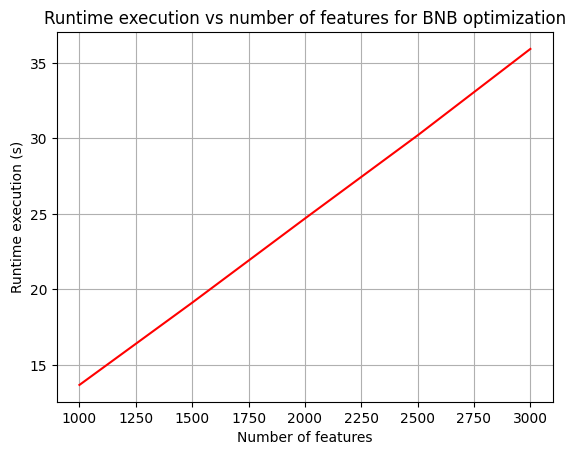

In [275]:
results = []
features = np.linspace(1000, 3000, 5, dtype = int)
for feature in features:
    trick = [key for key in execution.keys() if f'Number of features = {feature}' in key]
    results.append(np.mean([execution[key] for key in trick]))
plt.grid()
plt.plot(features, results, color = 'r')
plt.xlabel('Number of features')
plt.ylabel('Runtime execution (s)')
plt.title('Runtime execution vs number of features for BNB optimization')
plt.savefig('bnb.png')

In [80]:
# 10 folds Cross Validation with the hyperparameters yielding out the best values:
tfidf = normal = False
smooth = True
features, tokens = np.linspace(2500, 3000, 5, dtype = int), [None, LemmaTokenizer(), StemTokenizer()]
accuracies_, count, execution_ = {}, 1, {}
for n in features:
    for token in tokens:
        start = time.time()
        label = f'TF - IDF = {tfidf} | Normalization = {normal} | Laplace Smoothing = {smooth} | Number of features = {n} | Tokenizer = {token}'
        processor = TextProcessor(True, True, tfidf, token, normal, n)
        X = processor.trainX(train_corpus)
        model, validation = NaiveBayes(smooth), CrossValidation(10)
        accuracies_[label] = validation.validate(model, X, Y_train, False, unique_categories, False)
        end = time.time()
        step = end - start
        execution_[label] = step
        print(f'Iteration {count} out of 15 with TF - IDF = {t} | Normalization = {normal} | Laplace Smoothing = {s} | Number of features = {n} | Tokenizer = {token}')
        print(f'Iteration {count} was {step} s long')
        count += 1

Averrage accuracy of Naive Bayes is : 63.42 %
Iteration 1 out of 15 with TF - IDF = False | Normalization = False | Laplace Smoothing = False | Number of features = 2500 | Tokenizer = None
Iteration 1 was 27.656095027923584 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fu', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of Naive Bayes is : 61.47 %
Iteration 2 out of 15 with TF - IDF = False | Normalization = False | Laplace Smoothing = False | Number of features = 2500 | Tokenizer = Lemma Tokenizer
Iteration 2 was 35.36267900466919 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'aur', 'aurion', 'auron', 'avai', 'avion', 'avon', 'ayon', 'becaus', 'befor', 'could', 'dan', 'doe', 'dure', 'e', 'ell', 'euss', 'eussion', 'eûm', 'fu', 'fuss', 'fussion', 'fûm', 'ha', 'hi', 'mai', 'might', 'must', 'mêm', 'need', 'notr', 'onc', 'onli', 'ourselv', 'pa', 'ser', 'serion', 'seron', 'sha', 'soi', 'somm', 'soyon', 'themselv', 'thi', 'veri', 'vo', 'votr', 'vou', 'wa', 'whi', 'wo', 'would', 'yourselv', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(


Averrage accuracy of Naive Bayes is : 60.92 %
Iteration 3 out of 15 with TF - IDF = False | Normalization = False | Laplace Smoothing = False | Number of features = 2500 | Tokenizer = Stemming Tokenizer
Iteration 3 was 34.283665895462036 s long
Averrage accuracy of Naive Bayes is : 63.15 %
Iteration 4 out of 15 with TF - IDF = False | Normalization = False | Laplace Smoothing = False | Number of features = 2625 | Tokenizer = None
Iteration 4 was 29.12404990196228 s long
Averrage accuracy of Naive Bayes is : 62.44 %
Iteration 5 out of 15 with TF - IDF = False | Normalization = False | Laplace Smoothing = False | Number of features = 2625 | Tokenizer = Lemma Tokenizer
Iteration 5 was 34.52461576461792 s long
Averrage accuracy of Naive Bayes is : 61.34 %
Iteration 6 out of 15 with TF - IDF = False | Normalization = False | Laplace Smoothing = False | Number of features = 2625 | Tokenizer = Stemming Tokenizer
Iteration 6 was 32.43931293487549 s long
Averrage accuracy of Naive Bayes is : 62

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of Naive Bayes is : 62.03 %
Iteration 8 out of 15 with TF - IDF = False | Normalization = False | Laplace Smoothing = False | Number of features = 2750 | Tokenizer = Lemma Tokenizer
Iteration 8 was 36.18333077430725 s long
Averrage accuracy of Naive Bayes is : 61.06 %
Iteration 9 out of 15 with TF - IDF = False | Normalization = False | Laplace Smoothing = False | Number of features = 2750 | Tokenizer = Stemming Tokenizer
Iteration 9 was 32.996607065200806 s long
Averrage accuracy of Naive Bayes is : 63.43 %
Iteration 10 out of 15 with TF - IDF = False | Normalization = False | Laplace Smoothing = False | Number of features = 2875 | Tokenizer = None
Iteration 10 was 32.06395506858826 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of Naive Bayes is : 62.72 %
Iteration 11 out of 15 with TF - IDF = False | Normalization = False | Laplace Smoothing = False | Number of features = 2875 | Tokenizer = Lemma Tokenizer
Iteration 11 was 37.193110704422 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'aur', 'aurion', 'auron', 'avai', 'avion', 'avon', 'ayon', 'becaus', 'befor', 'could', 'dan', 'doe', 'dure', 'e', 'ell', 'euss', 'eussion', 'eûm', 'fuss', 'fussion', 'fûm', 'ha', 'hi', 'mai', 'might', 'must', 'mêm', 'need', 'notr', 'onc', 'onli', 'ourselv', 'pa', 'ser', 'serion', 'seron', 'sha', 'soi', 'somm', 'soyon', 'themselv', 'thi', 'veri', 'vo', 'votr', 'vou', 'wa', 'whi', 'wo', 'would', 'yourselv', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(


Averrage accuracy of Naive Bayes is : 61.06 %
Iteration 12 out of 15 with TF - IDF = False | Normalization = False | Laplace Smoothing = False | Number of features = 2875 | Tokenizer = Stemming Tokenizer
Iteration 12 was 35.23127007484436 s long
Averrage accuracy of Naive Bayes is : 63.15 %
Iteration 13 out of 15 with TF - IDF = False | Normalization = False | Laplace Smoothing = False | Number of features = 3000 | Tokenizer = None
Iteration 13 was 33.65102410316467 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of Naive Bayes is : 62.31 %
Iteration 14 out of 15 with TF - IDF = False | Normalization = False | Laplace Smoothing = False | Number of features = 3000 | Tokenizer = Lemma Tokenizer
Iteration 14 was 38.110538959503174 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'aur', 'aurion', 'auron', 'avai', 'avion', 'avon', 'ayon', 'becaus', 'befor', 'could', 'dan', 'doe', 'dure', 'e', 'ell', 'euss', 'eussion', 'eûm', 'fu', 'fuss', 'fussion', 'fûm', 'ha', 'hi', 'mai', 'might', 'must', 'mêm', 'need', 'notr', 'nou', 'onc', 'onli', 'ourselv', 'pa', 'ser', 'serion', 'seron', 'sha', 'soi', 'somm', 'soyon', 'themselv', 'thi', 'veri', 'vo', 'votr', 'vou', 'wa', 'whi', 'wo', 'would', 'yourselv', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(


Averrage accuracy of Naive Bayes is : 61.34 %
Iteration 15 out of 15 with TF - IDF = False | Normalization = False | Laplace Smoothing = False | Number of features = 3000 | Tokenizer = Stemming Tokenizer
Iteration 15 was 35.680952072143555 s long


In [83]:
index = max(accuracies_, key = accuracies_.get)
index

'TF - IDF = False | Normalization = False | Laplace Smoothing = True | Number of features = 2875 | Tokenizer = None'

# Compare results with Decision tree classifier


In [47]:
# Calls the SkLearn Decisio Tree Classifier
# This part of the code was to familiarize ourselves with the classifier

from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier


classes = unique_categories
classifier = DecisionTreeClassifier(max_features = max_features)
classifier.fit(X_train_vec, Y_train)

DecisionTreeClassifier(max_features=3000)

In [48]:
DTpred = classifier.predict(X_test)
DTpred

array([0, 0, 1, 3, 2, 3, 0, 2, 0, 1, 1, 1, 3, 3, 0, 2, 0, 2, 1, 1, 2, 2,
       0, 2, 2, 2, 3, 1, 3, 2, 0, 0, 0, 3, 2, 0, 1, 2, 0, 0, 3, 3, 3, 1,
       3, 3, 3, 2, 2, 3, 2, 1, 3, 1, 2, 2, 2, 1, 0, 1, 2, 0, 0, 0, 2, 3,
       3, 1, 0, 1, 2, 2, 3, 1, 3, 2, 2, 1, 2, 2, 0, 3, 0, 2, 2, 0, 1, 1,
       2, 0, 2, 0, 3, 1, 0, 2, 2, 2, 0, 1, 1, 3, 0, 0, 3, 2, 2, 2, 3, 2,
       0, 0, 1, 3, 2, 0, 2, 0, 0, 0, 3, 3, 3, 0, 3, 1, 1, 2, 2, 1, 3, 1,
       2, 0, 0, 3, 2, 2, 3, 0, 3, 0, 3, 0, 2, 0, 3, 2, 3, 1, 1, 3, 1, 0,
       2, 0, 1, 3, 1, 3, 3, 0, 0, 1, 0, 2, 2, 0, 0, 2, 3, 3, 3, 2, 3, 1,
       0, 1, 3, 2, 0, 3, 0, 0, 3, 2, 2, 2, 1, 3, 3, 0, 0, 1, 2, 1, 0, 2,
       2, 0, 0, 2, 2, 2, 0, 0, 1, 3, 0, 3, 1, 3, 1, 3, 0, 2, 2, 2, 3, 0,
       0, 3, 1, 2, 1, 2, 0, 3, 1, 2, 2, 3, 3, 3, 1, 1, 0, 2, 0, 0, 3, 3,
       3, 0, 0, 2, 3, 3, 3, 3, 1, 3, 1, 2, 2, 3, 3, 2, 2, 0, 2, 3, 1, 1,
       1, 0, 1, 2, 3, 3, 0, 0, 0, 0, 3, 2, 2, 2, 2])

In [57]:
test[90]

'Going to pick up our Turkey from the butcher then will brine it overnight before cooking for guests tomorrow. Food shopping, trip to LCBO for some wine, then prep prep prep, a walk to get the lead out, and then a light dinner before bed.'

In [69]:
unique_categories[DTpred[90]]

'London'

In [60]:
#10 folds CV on Decision Tree Classifier with no TF-IDF and no tokenizer
n_features, max_depth = np.linspace(1000, max_features, 5, dtype = int), [2,4,6,8,10,12]
accuracies_DT = {}
executions_DT = {}
count = 1
for n in n_features:
    for depth in max_depth:
        classifier, processor = DecisionTreeClassifier(max_features = n, max_depth = depth), TextProcessor(True, True, False, None, False, 2500)
        start = time.time()
        label = f'Number of features = {n} | Maximum depth = {depth}'
        X = processor.trainX(train_corpus)
        validation = CrossValidation(10)
        accuracies_DT[label] = validation.validate(classifier, X, Y_train, False, unique_categories, False)
        end = time.time()
        step = end - start
        executions_DT[label] = step
        print(f'Iteration {count} out of 120 with Number of features = {n} | Maximum depth = {depth}')
        print(f'Iteration {count} was {step} s long')
        count += 1

Averrage accuracy of DecisionTreeClassifier(max_depth=2, max_features=1000) is : 31.58 %
Iteration 1 out of 120 with Number of features = 1000 | Maximum depth = 2
Iteration 1 was 0.12614107131958008 s long
Averrage accuracy of DecisionTreeClassifier(max_depth=4, max_features=1000) is : 45.48 %
Iteration 2 out of 120 with Number of features = 1000 | Maximum depth = 4
Iteration 2 was 0.10445022583007812 s long
Averrage accuracy of DecisionTreeClassifier(max_depth=6, max_features=1000) is : 46.03 %
Iteration 3 out of 120 with Number of features = 1000 | Maximum depth = 6
Iteration 3 was 0.1342921257019043 s long
Averrage accuracy of DecisionTreeClassifier(max_depth=8, max_features=1000) is : 45.63 %
Iteration 4 out of 120 with Number of features = 1000 | Maximum depth = 8
Iteration 4 was 0.14693593978881836 s long
Averrage accuracy of DecisionTreeClassifier(max_depth=10, max_features=1000) is : 46.87 %
Iteration 5 out of 120 with Number of features = 1000 | Maximum depth = 10
Iteration 5 

In [276]:
u_DT = max(accuracies_DT, key = accuracies_DT.get)
accuracies_DT[u_DT]

0.5257629107981221

In [85]:
#10 folds CV on Decision Tree Classifier with TF-IDF and Lemma tokenizer
n_features, max_depth = np.linspace(1000, max_features, 5, dtype = int), [2,4,6,8,10,12]
accuracies_DT2 = {}
executions_DT2 = {}
token = LemmaTokenizer()
count = 1
for n in n_features:
    for depth in max_depth:
        classifier, processor = DecisionTreeClassifier(max_features = n, max_depth = depth), TextProcessor(True, True, True, token, False, n)
        start = time.time()
        label = f'Number of features = {n} | Maximum depth = {depth}'
        X = processor.trainX(train_corpus)
        validation = CrossValidation(10)
        accuracies_DT2[label] = validation.validate(classifier, X, Y_train, False, unique_categories, False)
        end = time.time()
        step = end - start
        executions_DT2[label] = step
        print(f'Iteration {count} out of 30 with Number of features = {n} | Maximum depth = {depth}')
        print(f'Iteration {count} was {step} s long')
        count += 1

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of DecisionTreeClassifier(max_depth=2, max_features=1000) is : 41.73 %
Iteration 1 out of 30 with Number of features = 1000 | Maximum depth = 2
Iteration 1 was 6.030891180038452 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of DecisionTreeClassifier(max_depth=4, max_features=1000) is : 46.32 %
Iteration 2 out of 30 with Number of features = 1000 | Maximum depth = 4
Iteration 2 was 4.902533054351807 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of DecisionTreeClassifier(max_depth=6, max_features=1000) is : 51.05 %
Iteration 3 out of 30 with Number of features = 1000 | Maximum depth = 6
Iteration 3 was 5.410880088806152 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fu', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'sha', 'win', 'wo', 'would', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of DecisionTreeClassifier(max_depth=8, max_features=1000) is : 55.36 %
Iteration 4 out of 30 with Number of features = 1000 | Maximum depth = 8
Iteration 4 was 5.074504852294922 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of DecisionTreeClassifier(max_depth=10, max_features=1000) is : 56.61 %
Iteration 5 out of 30 with Number of features = 1000 | Maximum depth = 10
Iteration 5 was 5.202574253082275 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of DecisionTreeClassifier(max_depth=12, max_features=1000) is : 56.47 %
Iteration 6 out of 30 with Number of features = 1000 | Maximum depth = 12
Iteration 6 was 5.198751926422119 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'sha', 'win', 'wo', 'would', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of DecisionTreeClassifier(max_depth=2, max_features=1500) is : 41.73 %
Iteration 7 out of 30 with Number of features = 1500 | Maximum depth = 2
Iteration 7 was 5.094727993011475 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of DecisionTreeClassifier(max_depth=4, max_features=1500) is : 47.16 %
Iteration 8 out of 30 with Number of features = 1500 | Maximum depth = 4
Iteration 8 was 5.0726540088653564 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fu', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of DecisionTreeClassifier(max_depth=6, max_features=1500) is : 50.91 %
Iteration 9 out of 30 with Number of features = 1500 | Maximum depth = 6
Iteration 9 was 5.110316038131714 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of DecisionTreeClassifier(max_depth=8, max_features=1500) is : 55.77 %
Iteration 10 out of 30 with Number of features = 1500 | Maximum depth = 8
Iteration 10 was 5.206772089004517 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of DecisionTreeClassifier(max_depth=10, max_features=1500) is : 54.66 %
Iteration 11 out of 30 with Number of features = 1500 | Maximum depth = 10
Iteration 11 was 5.369570016860962 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of DecisionTreeClassifier(max_depth=12, max_features=1500) is : 56.47 %
Iteration 12 out of 30 with Number of features = 1500 | Maximum depth = 12
Iteration 12 was 5.460327863693237 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avoir', 'eussion', 'eûme', 'eûte', 'fu', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of DecisionTreeClassifier(max_depth=2, max_features=2000) is : 41.45 %
Iteration 13 out of 30 with Number of features = 2000 | Maximum depth = 2
Iteration 13 was 5.020183086395264 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fu', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of DecisionTreeClassifier(max_depth=4, max_features=2000) is : 46.46 %
Iteration 14 out of 30 with Number of features = 2000 | Maximum depth = 4
Iteration 14 was 5.070353984832764 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fu', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of DecisionTreeClassifier(max_depth=6, max_features=2000) is : 50.21 %
Iteration 15 out of 30 with Number of features = 2000 | Maximum depth = 6
Iteration 15 was 5.165337085723877 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of DecisionTreeClassifier(max_depth=8, max_features=2000) is : 55.91 %
Iteration 16 out of 30 with Number of features = 2000 | Maximum depth = 8
Iteration 16 was 5.200932025909424 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of DecisionTreeClassifier(max_depth=10, max_features=2000) is : 54.52 %
Iteration 17 out of 30 with Number of features = 2000 | Maximum depth = 10
Iteration 17 was 5.234000205993652 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of DecisionTreeClassifier(max_depth=12, max_features=2000) is : 56.46 %
Iteration 18 out of 30 with Number of features = 2000 | Maximum depth = 12
Iteration 18 was 5.920997858047485 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of DecisionTreeClassifier(max_depth=2, max_features=2500) is : 42.01 %
Iteration 19 out of 30 with Number of features = 2500 | Maximum depth = 2
Iteration 19 was 5.2561211585998535 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of DecisionTreeClassifier(max_depth=4, max_features=2500) is : 46.6 %
Iteration 20 out of 30 with Number of features = 2500 | Maximum depth = 4
Iteration 20 was 5.296519994735718 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fu', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of DecisionTreeClassifier(max_depth=6, max_features=2500) is : 50.49 %
Iteration 21 out of 30 with Number of features = 2500 | Maximum depth = 6
Iteration 21 was 5.289938926696777 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of DecisionTreeClassifier(max_depth=8, max_features=2500) is : 55.63 %
Iteration 22 out of 30 with Number of features = 2500 | Maximum depth = 8
Iteration 22 was 5.2285120487213135 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of DecisionTreeClassifier(max_depth=10, max_features=2500) is : 54.24 %
Iteration 23 out of 30 with Number of features = 2500 | Maximum depth = 10
Iteration 23 was 5.36402702331543 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of DecisionTreeClassifier(max_depth=12, max_features=2500) is : 56.47 %
Iteration 24 out of 30 with Number of features = 2500 | Maximum depth = 12
Iteration 24 was 5.296278953552246 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of DecisionTreeClassifier(max_depth=2, max_features=3000) is : 42.01 %
Iteration 25 out of 30 with Number of features = 3000 | Maximum depth = 2
Iteration 25 was 5.098299026489258 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fu', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of DecisionTreeClassifier(max_depth=4, max_features=3000) is : 46.18 %
Iteration 26 out of 30 with Number of features = 3000 | Maximum depth = 4
Iteration 26 was 5.1980650424957275 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of DecisionTreeClassifier(max_depth=6, max_features=3000) is : 50.77 %
Iteration 27 out of 30 with Number of features = 3000 | Maximum depth = 6
Iteration 27 was 5.171403169631958 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of DecisionTreeClassifier(max_depth=8, max_features=3000) is : 55.36 %
Iteration 28 out of 30 with Number of features = 3000 | Maximum depth = 8
Iteration 28 was 5.242625951766968 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of DecisionTreeClassifier(max_depth=10, max_features=3000) is : 54.38 %
Iteration 29 out of 30 with Number of features = 3000 | Maximum depth = 10
Iteration 29 was 5.2567408084869385 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of DecisionTreeClassifier(max_depth=12, max_features=3000) is : 56.74 %
Iteration 30 out of 30 with Number of features = 3000 | Maximum depth = 12
Iteration 30 was 5.4533209800720215 s long


In [278]:
# Returns the maximum accuracy obtained
u_DT2= max(accuracies_DT2, key = accuracies_DT2.get)
accuracies_DT2[u_DT2]

0.5674491392801253

In [295]:
executions_DT2

{'Number of features = 1000 | Maximum depth = 2': 6.030891180038452,
 'Number of features = 1000 | Maximum depth = 4': 4.902533054351807,
 'Number of features = 1000 | Maximum depth = 6': 5.410880088806152,
 'Number of features = 1000 | Maximum depth = 8': 5.074504852294922,
 'Number of features = 1000 | Maximum depth = 10': 5.202574253082275,
 'Number of features = 1000 | Maximum depth = 12': 5.198751926422119,
 'Number of features = 1500 | Maximum depth = 2': 5.094727993011475,
 'Number of features = 1500 | Maximum depth = 4': 5.0726540088653564,
 'Number of features = 1500 | Maximum depth = 6': 5.110316038131714,
 'Number of features = 1500 | Maximum depth = 8': 5.206772089004517,
 'Number of features = 1500 | Maximum depth = 10': 5.369570016860962,
 'Number of features = 1500 | Maximum depth = 12': 5.460327863693237,
 'Number of features = 2000 | Maximum depth = 2': 5.020183086395264,
 'Number of features = 2000 | Maximum depth = 4': 5.070353984832764,
 'Number of features = 2000 |

In [280]:
u_DT2

'Number of features = 3000 | Maximum depth = 12'

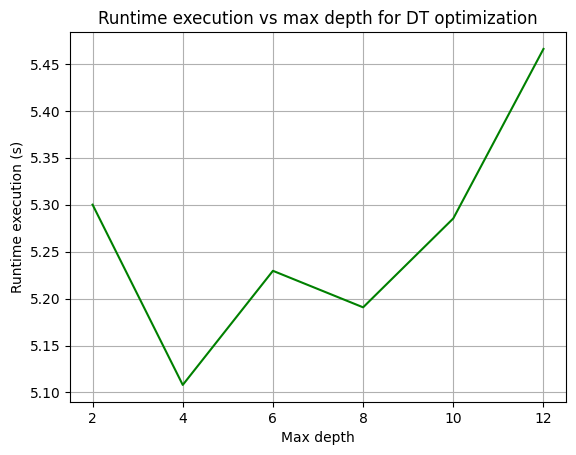

In [297]:
results = []
max_depth = [2, 4, 6, 8, 10, 12]
for d in max_depth:
    trick = [key for key in executions_DT2.keys() if f'Maximum depth = {d}' in key]
    results.append(np.mean([executions_DT2[key] for key in trick]))
plt.grid()
plt.plot(max_depth, results, color = 'g')
plt.xlabel('Max depth')
plt.ylabel('Runtime execution (s)')
plt.title('Runtime execution vs max depth for DT optimization')
plt.savefig('dt.png')

In [87]:
#10 folds CV on Decision Tree Classifier with TF-IDF and no tokenizer
n_features, max_depth = np.linspace(1000, max_features, 5, dtype = int), [2,4,6,8,10,12]
accuracies_DT3 = {}
executions_DT3 = {}
token = None
count = 1
for n in n_features:
    for depth in max_depth:
        classifier, processor = DecisionTreeClassifier(max_features = n, max_depth = depth), TextProcessor(True, True, True, token, False, n)
        start = time.time()
        label = f'Number of features = {n} | Maximum depth = {depth}'
        X = processor.trainX(train_corpus)
        validation = CrossValidation(10)
        accuracies_DT3[label] = validation.validate(classifier, X, Y_train, False, unique_categories, False)
        end = time.time()
        step = end - start
        executions_DT3[label] = step
        print(f'Iteration {count} out of 30 with Number of features = {n} | Maximum depth = {depth}')
        print(f'Iteration {count} was {step} s long')
        count += 1

Averrage accuracy of DecisionTreeClassifier(max_depth=2, max_features=1000) is : 37.41 %
Iteration 1 out of 30 with Number of features = 1000 | Maximum depth = 2
Iteration 1 was 0.1014249324798584 s long
Averrage accuracy of DecisionTreeClassifier(max_depth=4, max_features=1000) is : 45.76 %
Iteration 2 out of 30 with Number of features = 1000 | Maximum depth = 4
Iteration 2 was 0.10767316818237305 s long
Averrage accuracy of DecisionTreeClassifier(max_depth=6, max_features=1000) is : 46.04 %
Iteration 3 out of 30 with Number of features = 1000 | Maximum depth = 6
Iteration 3 was 0.13252997398376465 s long
Averrage accuracy of DecisionTreeClassifier(max_depth=8, max_features=1000) is : 46.46 %
Iteration 4 out of 30 with Number of features = 1000 | Maximum depth = 8
Iteration 4 was 0.16157293319702148 s long
Averrage accuracy of DecisionTreeClassifier(max_depth=10, max_features=1000) is : 48.12 %
Iteration 5 out of 30 with Number of features = 1000 | Maximum depth = 10
Iteration 5 was 0

In [279]:
u_DT3= max(accuracies_DT3, key = accuracies_DT3.get)
accuracies_DT3[u_DT3]

0.5020931142410017

In [112]:
%autoreload 2

In [253]:
import importlib
importlib.reload(textprocessor)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/aymenboustani/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/aymenboustani/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/aymenboustani/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aymenboustani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/aymenboustani/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/aymenboustani/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_dat

<module 'textprocessor' from '/Users/aymenboustani/Desktop/McGill/Fall 2023/ECSE 551/textprocessor.py'>

In [136]:
# 10 folds Cross Validation with the best hyperparameters, iterating over N-Grams:
smooth = True
tfidf = normal = False
ngrams = [(x, y) for x, y in product([1,2,3], repeat=2) if x <= y]
features, token = 2500, None
accuracies_N, count, execution_N = {}, 1, {}
for ngram in ngrams:
    start = time.time()
    label = f'TF - IDF = {tfidf} | Normalization = {normal} | Laplace Smoothing = {smooth} | Number of features = {features} | Tokenizer = {token} | Ngrams = {ngram}'
    processor = TextProcessor(True, True, tfidf, token, normal, features, ngram)
    X = processor.trainX(train_corpus)
    model, validation = NaiveBayes(smooth), CrossValidation(10)
    accuracies_N[label] = validation.validate(model, X, Y_train, False, unique_categories, False)
    end = time.time()
    step = end - start
    execution_N[label] = step
    print(f'Iteration {count} out of 6 with TF - IDF = {tfidf} | Normalization = {normal} | Laplace Smoothing = {smooth} | Number of features = {features} | Tokenizer = {token} | Ngrams = {ngram}')
    print(f'Iteration {count} was {step} s long')
    count += 1

Averrage accuracy of Naive Bayes is : 63.42 %
Iteration 1 out of 6 with TF - IDF = False | Normalization = False | Laplace Smoothing = True | Number of features = 2500 | Tokenizer = None | Ngrams = (1, 1)
Iteration 1 was 27.71610713005066 s long
Averrage accuracy of Naive Bayes is : 60.49 %
Iteration 2 out of 6 with TF - IDF = False | Normalization = False | Laplace Smoothing = True | Number of features = 2500 | Tokenizer = None | Ngrams = (1, 2)
Iteration 2 was 28.361444234848022 s long
Averrage accuracy of Naive Bayes is : 60.22 %
Iteration 3 out of 6 with TF - IDF = False | Normalization = False | Laplace Smoothing = True | Number of features = 2500 | Tokenizer = None | Ngrams = (1, 3)
Iteration 3 was 28.131960153579712 s long
Averrage accuracy of Naive Bayes is : 44.5 %
Iteration 4 out of 6 with TF - IDF = False | Normalization = False | Laplace Smoothing = True | Number of features = 2500 | Tokenizer = None | Ngrams = (2, 2)
Iteration 4 was 27.602159023284912 s long
Averrage accur

In [137]:
# 10 folds Cross Validation with the best hyperparameters, iterating over N-Grams and number of features:
smooth = True
tfidf = normal = False
ngrams = [(x, y) for x, y in product([1,2,3], repeat=2) if x <= y]
features, token = np.linspace(1000,3000,5,dtype = int), None
accuracies_N2, count, execution_N2 = {}, 1, {}
for n in features:
    for ngram in ngrams:
        start = time.time()
        label = f'TF - IDF = {tfidf} | Normalization = {normal} | Laplace Smoothing = {smooth} | Number of features = {n} | Tokenizer = {token} | Ngrams = {ngram}'
        processor = TextProcessor(True, True, tfidf, token, normal, n, ngram)
        X = processor.trainX(train_corpus)
        model, validation = NaiveBayes(smooth), CrossValidation(10)
        accuracies_N2[label] = validation.validate(model, X, Y_train, False, unique_categories, False)
        end = time.time()
        step = end - start
        execution_N2[label] = step
        print(f'Iteration {count} out of 30 with TF - IDF = {tfidf} | Normalization = {normal} | Laplace Smoothing = {smooth} | Number of features = {n} | Tokenizer = {token} | Ngrams = {ngram}')
        print(f'Iteration {count} was {step} s long')
        count += 1

Averrage accuracy of Naive Bayes is : 58.27 %
Iteration 1 out of 30 with TF - IDF = False | Normalization = False | Laplace Smoothing = True | Number of features = 1000 | Tokenizer = None | Ngrams = (1, 1)
Iteration 1 was 10.865885972976685 s long
Averrage accuracy of Naive Bayes is : 57.02 %
Iteration 2 out of 30 with TF - IDF = False | Normalization = False | Laplace Smoothing = True | Number of features = 1000 | Tokenizer = None | Ngrams = (1, 2)
Iteration 2 was 11.205652952194214 s long
Averrage accuracy of Naive Bayes is : 55.07 %
Iteration 3 out of 30 with TF - IDF = False | Normalization = False | Laplace Smoothing = True | Number of features = 1000 | Tokenizer = None | Ngrams = (1, 3)
Iteration 3 was 11.175888061523438 s long
Averrage accuracy of Naive Bayes is : 45.2 %
Iteration 4 out of 30 with TF - IDF = False | Normalization = False | Laplace Smoothing = True | Number of features = 1000 | Tokenizer = None | Ngrams = (2, 2)
Iteration 4 was 11.407249927520752 s long
Averrage 

In [138]:
# 10 folds Cross Validation with iteration beyond 3000 features(no token, normalization, tfidf, ngrams = (1,1))
smooth = True
tfidf = normal = False
ngrams = (1,1)
features, token = np.linspace(2500,5000,5,dtype = int), None
accuracies_N3, count, execution_N3 = {}, 1, {}
for n in features:
    start = time.time()
    label = f'TF - IDF = {tfidf} | Normalization = {normal} | Laplace Smoothing = {smooth} | Number of features = {n} | Tokenizer = {token} | Ngrams = {ngrams}'
    processor = TextProcessor(True, True, tfidf, token, normal, n, ngrams)
    X = processor.trainX(train_corpus)
    model, validation = NaiveBayes(smooth), CrossValidation(10)
    accuracies_N3[label] = validation.validate(model, X, Y_train, False, unique_categories, False)
    end = time.time()
    step = end - start
    execution_N3[label] = step
    print(f'Iteration {count} out of 5 with TF - IDF = {tfidf} | Normalization = {normal} | Laplace Smoothing = {smooth} | Number of features = {n} | Tokenizer = {token} | Ngrams = {ngrams}')
    print(f'Iteration {count} was {step} s long')
    count += 1

Averrage accuracy of Naive Bayes is : 63.42 %
Iteration 1 out of 5 with TF - IDF = False | Normalization = False | Laplace Smoothing = True | Number of features = 2500 | Tokenizer = None | Ngrams = (1, 1)
Iteration 1 was 27.73598599433899 s long
Averrage accuracy of Naive Bayes is : 62.87 %
Iteration 2 out of 5 with TF - IDF = False | Normalization = False | Laplace Smoothing = True | Number of features = 3125 | Tokenizer = None | Ngrams = (1, 1)
Iteration 2 was 34.52015995979309 s long
Averrage accuracy of Naive Bayes is : 63.15 %
Iteration 3 out of 5 with TF - IDF = False | Normalization = False | Laplace Smoothing = True | Number of features = 3750 | Tokenizer = None | Ngrams = (1, 1)
Iteration 3 was 42.23354196548462 s long
Averrage accuracy of Naive Bayes is : 62.59 %
Iteration 4 out of 5 with TF - IDF = False | Normalization = False | Laplace Smoothing = True | Number of features = 4375 | Tokenizer = None | Ngrams = (1, 1)
Iteration 4 was 49.51335597038269 s long
Averrage accurac

In [140]:
len(test_corpus)

279

In [152]:
#10 folds CV using Stacking

estimators = [
    ('DecisionTree', DecisionTreeClassifier()),
    ('RandomForest', RandomForestClassifier()),
    ('BNB', BernoulliNB()),
    ('LogisticRegression', LogisticRegression()),
    ('SVM', LinearSVC(dual = True)),
    ('MNB', MultinomialNB())
]

classifier = StackingClassifier(estimators = estimators)


tfidf = normalization = [True, False]
features, tokens = np.linspace(1000, 3000, 5, dtype = int), [None, LemmaTokenizer(), StemTokenizer()]
accuracies_stacking, count, execution_stacking = {}, 1, {}
for t in tfidf:
    for normal in normalization:
        for n in features:
            for token in tokens:
                start = time.time()
                label = f'TF - IDF = {t} | Normalization = {normal} | Laplace Smoothing = True | Number of features = {n} | Tokenizer = {token}'
                processor = TextProcessor(True, True, t, token, normal, n)
                X = processor.trainX(train_corpus)
                model, validation = classifier, CrossValidation(10)
                accuracies_stacking[label] = validation.validate(model, X, Y_train, False, unique_categories, False)
                end = time.time()
                step = end - start
                execution_stacking[label] = step
                print(f'Iteration {count} out of 60 with TF - IDF = {t} | Normalization = {normal} | Laplace Smoothing = True | Number of features = {n} | Tokenizer = {token}')
                print(f'Iteration {count} was {step} s long')
                count += 1

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Averrage accuracy of StackingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('RandomForest', RandomForestClassifier()),
                               ('BNB', BernoulliNB()),
                               ('LogisticRegression', LogisticRegression()),
                               ('SVM', LinearSVC(dual=True)),
                               ('MNB', MultinomialNB())]) is : 61.76 %
Iteration 1 out of 60 with TF - IDF = True | Normalization = True | Laplace Smoothing = True | Number of features = 1000 | Tokenizer = None
Iteration 1 was 18.83707308769226 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fu', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as sh

Averrage accuracy of StackingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('RandomForest', RandomForestClassifier()),
                               ('BNB', BernoulliNB()),
                               ('LogisticRegression', LogisticRegression()),
                               ('SVM', LinearSVC(dual=True)),
                               ('MNB', MultinomialNB())]) is : 62.86 %
Iteration 2 out of 60 with TF - IDF = True | Normalization = True | Laplace Smoothing = True | Number of features = 1000 | Tokenizer = Lemma Tokenizer
Iteration 2 was 25.305021286010742 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'aur', 'aurion', 'auron', 'avai', 'avion', 'avon', 'ayon', 'becaus', 'befor', 'could', 'dan', 'doe', 'dure', 'e', 'ell', 'euss', 'eussion', 'eûm', 'fu', 'fuss', 'fussion', 'fûm', 'ha', 'hi', 'mai', 'might', 'must', 'mêm', 'need', 'notr', 'onc', 'onli', 'ourselv', 'pa', 'ser', 'serion', 'seron', 'sha', 'soi', 'somm', 'soyon', 'themselv', 'thi', 'veri', 'vo', 'votr', 'vou', 'wa', 'whi', 'wo', 'would', 'yourselv', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions

Averrage accuracy of StackingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('RandomForest', RandomForestClassifier()),
                               ('BNB', BernoulliNB()),
                               ('LogisticRegression', LogisticRegression()),
                               ('SVM', LinearSVC(dual=True)),
                               ('MNB', MultinomialNB())]) is : 63.15 %
Iteration 3 out of 60 with TF - IDF = True | Normalization = True | Laplace Smoothing = True | Number of features = 1000 | Tokenizer = Stemming Tokenizer
Iteration 3 was 23.215051889419556 s long
Averrage accuracy of StackingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('RandomForest', RandomForestClassifier()),
                               ('BNB', BernoulliNB()),
                               ('LogisticRegression', LogisticRegression()),
                               ('SVM', LinearSVC(dual=True)),
   

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https:

Averrage accuracy of StackingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('RandomForest', RandomForestClassifier()),
                               ('BNB', BernoulliNB()),
                               ('LogisticRegression', LogisticRegression()),
                               ('SVM', LinearSVC(dual=True)),
                               ('MNB', MultinomialNB())]) is : 64.95 %
Iteration 5 out of 60 with TF - IDF = True | Normalization = True | Laplace Smoothing = True | Number of features = 1500 | Tokenizer = Lemma Tokenizer
Iteration 5 was 26.016488075256348 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'aur', 'aurion', 'auron', 'avai', 'avion', 'avon', 'ayon', 'becaus', 'befor', 'could', 'dan', 'doe', 'dure', 'e', 'ell', 'euss', 'eussion', 'eûm', 'fuss', 'fussion', 'fûm', 'ha', 'hi', 'mai', 'might', 'must', 'mêm', 'need', 'notr', 'onc', 'onli', 'ourselv', 'pa', 'ser', 'serion', 'seron', 'sha', 'soi', 'somm', 'soyon', 'themselv', 'thi', 'veri', 'vo', 'votr', 'vou', 'wa', 'whi', 'wo', 'would', 'yourselv', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/

Averrage accuracy of StackingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('RandomForest', RandomForestClassifier()),
                               ('BNB', BernoulliNB()),
                               ('LogisticRegression', LogisticRegression()),
                               ('SVM', LinearSVC(dual=True)),
                               ('MNB', MultinomialNB())]) is : 64.68 %
Iteration 6 out of 60 with TF - IDF = True | Normalization = True | Laplace Smoothing = True | Number of features = 1500 | Tokenizer = Stemming Tokenizer
Iteration 6 was 23.59811806678772 s long
Averrage accuracy of StackingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('RandomForest', RandomForestClassifier()),
                               ('BNB', BernoulliNB()),
                               ('LogisticRegression', LogisticRegression()),
                               ('SVM', LinearSVC(dual=True)),
    

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    htt

Averrage accuracy of StackingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('RandomForest', RandomForestClassifier()),
                               ('BNB', BernoulliNB()),
                               ('LogisticRegression', LogisticRegression()),
                               ('SVM', LinearSVC(dual=True)),
                               ('MNB', MultinomialNB())]) is : 66.48 %
Iteration 8 out of 60 with TF - IDF = True | Normalization = True | Laplace Smoothing = True | Number of features = 2000 | Tokenizer = Lemma Tokenizer
Iteration 8 was 31.24337887763977 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'aur', 'aurion', 'auron', 'avai', 'avion', 'avon', 'ayon', 'becaus', 'befor', 'could', 'dan', 'doe', 'e', 'ell', 'euss', 'eussion', 'eûm', 'fu', 'fuss', 'fussion', 'fûm', 'ha', 'hi', 'mai', 'might', 'must', 'mêm', 'need', 'notr', 'onc', 'onli', 'ourselv', 'pa', 'ser', 'serion', 'seron', 'sha', 'soi', 'somm', 'soyon', 'themselv', 'thi', 'veri', 'vo', 'votr', 'vou', 'wa', 'whi', 'wo', 'would', 'yourselv', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(


Averrage accuracy of StackingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('RandomForest', RandomForestClassifier()),
                               ('BNB', BernoulliNB()),
                               ('LogisticRegression', LogisticRegression()),
                               ('SVM', LinearSVC(dual=True)),
                               ('MNB', MultinomialNB())]) is : 65.51 %
Iteration 9 out of 60 with TF - IDF = True | Normalization = True | Laplace Smoothing = True | Number of features = 2000 | Tokenizer = Stemming Tokenizer
Iteration 9 was 25.895270824432373 s long
Averrage accuracy of StackingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('RandomForest', RandomForestClassifier()),
                               ('BNB', BernoulliNB()),
                               ('LogisticRegression', LogisticRegression()),
                               ('SVM', LinearSVC(dual=True)),
   

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of StackingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('RandomForest', RandomForestClassifier()),
                               ('BNB', BernoulliNB()),
                               ('LogisticRegression', LogisticRegression()),
                               ('SVM', LinearSVC(dual=True)),
                               ('MNB', MultinomialNB())]) is : 66.34 %
Iteration 11 out of 60 with TF - IDF = True | Normalization = True | Laplace Smoothing = True | Number of features = 2500 | Tokenizer = Lemma Tokenizer
Iteration 11 was 54.62567400932312 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'aur', 'aurion', 'auron', 'avai', 'avion', 'avon', 'ayon', 'becaus', 'befor', 'could', 'dan', 'doe', 'dure', 'e', 'ell', 'euss', 'eussion', 'eûm', 'fu', 'fuss', 'fussion', 'fûm', 'ha', 'hi', 'mai', 'might', 'must', 'mêm', 'need', 'notr', 'onc', 'onli', 'ourselv', 'pa', 'ser', 'serion', 'seron', 'sha', 'soi', 'somm', 'soyon', 'themselv', 'thi', 'veri', 'vo', 'votr', 'vou', 'wa', 'whi', 'wo', 'would', 'yourselv', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions

Averrage accuracy of StackingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('RandomForest', RandomForestClassifier()),
                               ('BNB', BernoulliNB()),
                               ('LogisticRegression', LogisticRegression()),
                               ('SVM', LinearSVC(dual=True)),
                               ('MNB', MultinomialNB())]) is : 65.23 %
Iteration 12 out of 60 with TF - IDF = True | Normalization = True | Laplace Smoothing = True | Number of features = 2500 | Tokenizer = Stemming Tokenizer
Iteration 12 was 59.418282985687256 s long
Averrage accuracy of StackingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('RandomForest', RandomForestClassifier()),
                               ('BNB', BernoulliNB()),
                               ('LogisticRegression', LogisticRegression()),
                               ('SVM', LinearSVC(dual=True)),
 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fu', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of StackingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('RandomForest', RandomForestClassifier()),
                               ('BNB', BernoulliNB()),
                               ('LogisticRegression', LogisticRegression()),
                               ('SVM', LinearSVC(dual=True)),
                               ('MNB', MultinomialNB())]) is : 67.59 %
Iteration 14 out of 60 with TF - IDF = True | Normalization = True | Laplace Smoothing = True | Number of features = 3000 | Tokenizer = Lemma Tokenizer
Iteration 14 was 59.992876052856445 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'aur', 'aurion', 'auron', 'avai', 'avion', 'avon', 'ayon', 'becaus', 'befor', 'could', 'dan', 'doe', 'dure', 'e', 'ell', 'euss', 'eussion', 'eûm', 'fu', 'fuss', 'fussion', 'fûm', 'ha', 'hi', 'mai', 'might', 'must', 'mêm', 'need', 'notr', 'onc', 'onli', 'ourselv', 'pa', 'ser', 'serion', 'seron', 'sha', 'soi', 'somm', 'soyon', 'themselv', 'thi', 'veri', 'vo', 'votr', 'vou', 'wa', 'whi', 'wo', 'would', 'yourselv', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(


Averrage accuracy of StackingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('RandomForest', RandomForestClassifier()),
                               ('BNB', BernoulliNB()),
                               ('LogisticRegression', LogisticRegression()),
                               ('SVM', LinearSVC(dual=True)),
                               ('MNB', MultinomialNB())]) is : 65.65 %
Iteration 15 out of 60 with TF - IDF = True | Normalization = True | Laplace Smoothing = True | Number of features = 3000 | Tokenizer = Stemming Tokenizer
Iteration 15 was 61.09148979187012 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Averrage accuracy of StackingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('RandomForest', RandomForestClassifier()),
                               ('BNB', BernoulliNB()),
                               ('LogisticRegression', LogisticRegression()),
                               ('SVM', LinearSVC(dual=True)),
                               ('MNB', MultinomialNB())]) is : 62.03 %
Iteration 16 out of 60 with TF - IDF = True | Normalization = False | Laplace Smoothing = True | Number of features = 1000 | Tokenizer = None
Iteration 16 was 17.952518224716187 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    htt

Averrage accuracy of StackingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('RandomForest', RandomForestClassifier()),
                               ('BNB', BernoulliNB()),
                               ('LogisticRegression', LogisticRegression()),
                               ('SVM', LinearSVC(dual=True)),
                               ('MNB', MultinomialNB())]) is : 62.03 %
Iteration 17 out of 60 with TF - IDF = True | Normalization = False | Laplace Smoothing = True | Number of features = 1000 | Tokenizer = Lemma Tokenizer
Iteration 17 was 24.460514068603516 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'aur', 'aurion', 'auron', 'avai', 'avion', 'avon', 'ayon', 'becaus', 'befor', 'could', 'dan', 'doe', 'e', 'ell', 'euss', 'eussion', 'eûm', 'fuss', 'fussion', 'fûm', 'ha', 'hi', 'mai', 'might', 'must', 'mêm', 'need', 'notr', 'onc', 'onli', 'ourselv', 'pa', 'ser', 'serion', 'seron', 'sha', 'soi', 'somm', 'soyon', 'themselv', 'thi', 'veri', 'vo', 'votr', 'vou', 'wa', 'whi', 'wo', 'would', 'yourselv', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/pyth

Averrage accuracy of StackingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('RandomForest', RandomForestClassifier()),
                               ('BNB', BernoulliNB()),
                               ('LogisticRegression', LogisticRegression()),
                               ('SVM', LinearSVC(dual=True)),
                               ('MNB', MultinomialNB())]) is : 63.15 %
Iteration 18 out of 60 with TF - IDF = True | Normalization = False | Laplace Smoothing = True | Number of features = 1000 | Tokenizer = Stemming Tokenizer
Iteration 18 was 22.72874402999878 s long
Averrage accuracy of StackingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('RandomForest', RandomForestClassifier()),
                               ('BNB', BernoulliNB()),
                               ('LogisticRegression', LogisticRegression()),
                               ('SVM', LinearSVC(dual=True)),
 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    htt

Averrage accuracy of StackingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('RandomForest', RandomForestClassifier()),
                               ('BNB', BernoulliNB()),
                               ('LogisticRegression', LogisticRegression()),
                               ('SVM', LinearSVC(dual=True)),
                               ('MNB', MultinomialNB())]) is : 65.09 %
Iteration 20 out of 60 with TF - IDF = True | Normalization = False | Laplace Smoothing = True | Number of features = 1500 | Tokenizer = Lemma Tokenizer
Iteration 20 was 25.821383953094482 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'aur', 'aurion', 'auron', 'avai', 'avion', 'avon', 'ayon', 'becaus', 'befor', 'could', 'dan', 'doe', 'dure', 'e', 'ell', 'euss', 'eussion', 'eûm', 'fu', 'fuss', 'fussion', 'fûm', 'ha', 'hi', 'mai', 'might', 'must', 'mêm', 'need', 'notr', 'onc', 'onli', 'ourselv', 'pa', 'ser', 'serion', 'seron', 'sha', 'soi', 'somm', 'soyon', 'themselv', 'thi', 'veri', 'vo', 'votr', 'vou', 'wa', 'whi', 'wo', 'would', 'yourselv', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(


Averrage accuracy of StackingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('RandomForest', RandomForestClassifier()),
                               ('BNB', BernoulliNB()),
                               ('LogisticRegression', LogisticRegression()),
                               ('SVM', LinearSVC(dual=True)),
                               ('MNB', MultinomialNB())]) is : 63.42 %
Iteration 21 out of 60 with TF - IDF = True | Normalization = False | Laplace Smoothing = True | Number of features = 1500 | Tokenizer = Stemming Tokenizer
Iteration 21 was 23.715954303741455 s long
Averrage accuracy of StackingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('RandomForest', RandomForestClassifier()),
                               ('BNB', BernoulliNB()),
                               ('LogisticRegression', LogisticRegression()),
                               ('SVM', LinearSVC(dual=True)),


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fu', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of StackingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('RandomForest', RandomForestClassifier()),
                               ('BNB', BernoulliNB()),
                               ('LogisticRegression', LogisticRegression()),
                               ('SVM', LinearSVC(dual=True)),
                               ('MNB', MultinomialNB())]) is : 65.37 %
Iteration 23 out of 60 with TF - IDF = True | Normalization = False | Laplace Smoothing = True | Number of features = 2000 | Tokenizer = Lemma Tokenizer
Iteration 23 was 29.180658102035522 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'aur', 'aurion', 'auron', 'avai', 'avion', 'avon', 'ayon', 'becaus', 'befor', 'could', 'dan', 'doe', 'dure', 'e', 'ell', 'euss', 'eussion', 'eûm', 'fu', 'fuss', 'fussion', 'fûm', 'ha', 'hi', 'mai', 'might', 'must', 'mêm', 'need', 'notr', 'nou', 'onc', 'onli', 'ourselv', 'pa', 'ser', 'serion', 'seron', 'sha', 'soi', 'somm', 'soyon', 'themselv', 'thi', 'veri', 'vo', 'votr', 'vou', 'wa', 'whi', 'wo', 'would', 'yourselv', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(


Averrage accuracy of StackingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('RandomForest', RandomForestClassifier()),
                               ('BNB', BernoulliNB()),
                               ('LogisticRegression', LogisticRegression()),
                               ('SVM', LinearSVC(dual=True)),
                               ('MNB', MultinomialNB())]) is : 64.53 %
Iteration 24 out of 60 with TF - IDF = True | Normalization = False | Laplace Smoothing = True | Number of features = 2000 | Tokenizer = Stemming Tokenizer
Iteration 24 was 28.39884638786316 s long
Averrage accuracy of StackingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('RandomForest', RandomForestClassifier()),
                               ('BNB', BernoulliNB()),
                               ('LogisticRegression', LogisticRegression()),
                               ('SVM', LinearSVC(dual=True)),
 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of StackingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('RandomForest', RandomForestClassifier()),
                               ('BNB', BernoulliNB()),
                               ('LogisticRegression', LogisticRegression()),
                               ('SVM', LinearSVC(dual=True)),
                               ('MNB', MultinomialNB())]) is : 66.06 %
Iteration 26 out of 60 with TF - IDF = True | Normalization = False | Laplace Smoothing = True | Number of features = 2500 | Tokenizer = Lemma Tokenizer
Iteration 26 was 62.300007820129395 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'aur', 'aurion', 'auron', 'avai', 'avion', 'avon', 'ayon', 'becaus', 'befor', 'could', 'dan', 'doe', 'dure', 'e', 'ell', 'euss', 'eussion', 'eûm', 'fuss', 'fussion', 'fûm', 'ha', 'hi', 'mai', 'might', 'must', 'mêm', 'need', 'notr', 'onc', 'onli', 'ourselv', 'pa', 'ser', 'serion', 'seron', 'sha', 'soi', 'somm', 'soyon', 'themselv', 'thi', 'veri', 'vo', 'votr', 'vou', 'wa', 'whi', 'wo', 'would', 'yourselv', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/

Averrage accuracy of StackingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('RandomForest', RandomForestClassifier()),
                               ('BNB', BernoulliNB()),
                               ('LogisticRegression', LogisticRegression()),
                               ('SVM', LinearSVC(dual=True)),
                               ('MNB', MultinomialNB())]) is : 65.51 %
Iteration 27 out of 60 with TF - IDF = True | Normalization = False | Laplace Smoothing = True | Number of features = 2500 | Tokenizer = Stemming Tokenizer
Iteration 27 was 62.88877892494202 s long
Averrage accuracy of StackingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('RandomForest', RandomForestClassifier()),
                               ('BNB', BernoulliNB()),
                               ('LogisticRegression', LogisticRegression()),
                               ('SVM', LinearSVC(dual=True)),
 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of StackingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('RandomForest', RandomForestClassifier()),
                               ('BNB', BernoulliNB()),
                               ('LogisticRegression', LogisticRegression()),
                               ('SVM', LinearSVC(dual=True)),
                               ('MNB', MultinomialNB())]) is : 66.9 %
Iteration 29 out of 60 with TF - IDF = True | Normalization = False | Laplace Smoothing = True | Number of features = 3000 | Tokenizer = Lemma Tokenizer
Iteration 29 was 68.39543581008911 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'aur', 'aurion', 'auron', 'avai', 'avion', 'avon', 'ayon', 'becaus', 'befor', 'could', 'dan', 'doe', 'dure', 'e', 'ell', 'euss', 'eussion', 'eûm', 'fuss', 'fussion', 'fûm', 'ha', 'hi', 'mai', 'might', 'must', 'mêm', 'need', 'notr', 'onc', 'onli', 'ourselv', 'pa', 'ser', 'serion', 'seron', 'sha', 'soi', 'somm', 'soyon', 'themselv', 'thi', 'veri', 'vo', 'votr', 'vou', 'wa', 'whi', 'wo', 'would', 'yourselv', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(


Averrage accuracy of StackingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('RandomForest', RandomForestClassifier()),
                               ('BNB', BernoulliNB()),
                               ('LogisticRegression', LogisticRegression()),
                               ('SVM', LinearSVC(dual=True)),
                               ('MNB', MultinomialNB())]) is : 66.48 %
Iteration 30 out of 60 with TF - IDF = True | Normalization = False | Laplace Smoothing = True | Number of features = 3000 | Tokenizer = Stemming Tokenizer
Iteration 30 was 59.46806502342224 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

Averrage accuracy of StackingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('RandomForest', RandomForestClassifier()),
                               ('BNB', BernoulliNB()),
                               ('LogisticRegression', LogisticRegression()),
                               ('SVM', LinearSVC(dual=True)),
                               ('MNB', MultinomialNB())]) is : 63.01 %
Iteration 31 out of 60 with TF - IDF = False | Normalization = True | Laplace Smoothing = True | Number of features = 1000 | Tokenizer = None
Iteration 31 was 26.096591234207153 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in

Averrage accuracy of StackingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('RandomForest', RandomForestClassifier()),
                               ('BNB', BernoulliNB()),
                               ('LogisticRegression', LogisticRegression()),
                               ('SVM', LinearSVC(dual=True)),
                               ('MNB', MultinomialNB())]) is : 61.61 %
Iteration 32 out of 60 with TF - IDF = False | Normalization = True | Laplace Smoothing = True | Number of features = 1000 | Tokenizer = Lemma Tokenizer
Iteration 32 was 29.438498973846436 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'aur', 'aurion', 'auron', 'avai', 'avion', 'avon', 'ayon', 'becaus', 'befor', 'could', 'dan', 'doe', 'dure', 'e', 'ell', 'euss', 'eussion', 'eûm', 'fu', 'fuss', 'fussion', 'fûm', 'ha', 'hi', 'mai', 'might', 'must', 'mêm', 'need', 'notr', 'onc', 'onli', 'ourselv', 'pa', 'ser', 'serion', 'seron', 'sha', 'soi', 'somm', 'soyon', 'themselv', 'thi', 'veri', 'vo', 'votr', 'vou', 'wa', 'whi', 'wo', 'would', 'yourselv', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions

Averrage accuracy of StackingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('RandomForest', RandomForestClassifier()),
                               ('BNB', BernoulliNB()),
                               ('LogisticRegression', LogisticRegression()),
                               ('SVM', LinearSVC(dual=True)),
                               ('MNB', MultinomialNB())]) is : 63.56 %
Iteration 33 out of 60 with TF - IDF = False | Normalization = True | Laplace Smoothing = True | Number of features = 1000 | Tokenizer = Stemming Tokenizer
Iteration 33 was 27.09192180633545 s long
Averrage accuracy of StackingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('RandomForest', RandomForestClassifier()),
                               ('BNB', BernoulliNB()),
                               ('LogisticRegression', LogisticRegression()),
                               ('SVM', LinearSVC(dual=True)),
 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    htt

Averrage accuracy of StackingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('RandomForest', RandomForestClassifier()),
                               ('BNB', BernoulliNB()),
                               ('LogisticRegression', LogisticRegression()),
                               ('SVM', LinearSVC(dual=True)),
                               ('MNB', MultinomialNB())]) is : 63.98 %
Iteration 35 out of 60 with TF - IDF = False | Normalization = True | Laplace Smoothing = True | Number of features = 1500 | Tokenizer = Lemma Tokenizer
Iteration 35 was 32.27924299240112 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'aur', 'aurion', 'auron', 'avai', 'avion', 'avon', 'ayon', 'becaus', 'befor', 'could', 'dan', 'doe', 'e', 'ell', 'euss', 'eussion', 'eûm', 'fu', 'fuss', 'fussion', 'fûm', 'ha', 'hi', 'mai', 'might', 'must', 'mêm', 'need', 'notr', 'onc', 'onli', 'ourselv', 'pa', 'ser', 'serion', 'seron', 'sha', 'soi', 'somm', 'soyon', 'themselv', 'thi', 'veri', 'vo', 'votr', 'vou', 'wa', 'whi', 'wo', 'would', 'yourselv', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/li

Averrage accuracy of StackingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('RandomForest', RandomForestClassifier()),
                               ('BNB', BernoulliNB()),
                               ('LogisticRegression', LogisticRegression()),
                               ('SVM', LinearSVC(dual=True)),
                               ('MNB', MultinomialNB())]) is : 64.12 %
Iteration 36 out of 60 with TF - IDF = False | Normalization = True | Laplace Smoothing = True | Number of features = 1500 | Tokenizer = Stemming Tokenizer
Iteration 36 was 35.87659692764282 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Averrage accuracy of StackingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('RandomForest', RandomForestClassifier()),
                               ('BNB', BernoulliNB()),
                               ('LogisticRegression', LogisticRegression()),
                               ('SVM', LinearSVC(dual=True)),
                               ('MNB', MultinomialNB())]) is : 63.56 %
Iteration 37 out of 60 with TF - IDF = False | Normalization = True | Laplace Smoothing = True | Number of features = 2000 | Tokenizer = None
Iteration 37 was 36.25053429603577 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avoir', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scik

Averrage accuracy of StackingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('RandomForest', RandomForestClassifier()),
                               ('BNB', BernoulliNB()),
                               ('LogisticRegression', LogisticRegression()),
                               ('SVM', LinearSVC(dual=True)),
                               ('MNB', MultinomialNB())]) is : 65.65 %
Iteration 38 out of 60 with TF - IDF = False | Normalization = True | Laplace Smoothing = True | Number of features = 2000 | Tokenizer = Lemma Tokenizer
Iteration 38 was 43.7914092540741 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'aur', 'aurion', 'auron', 'avai', 'avion', 'avon', 'ayon', 'becaus', 'befor', 'could', 'dan', 'doe', 'dure', 'e', 'ell', 'euss', 'eussion', 'eûm', 'fu', 'fuss', 'fussion', 'fûm', 'ha', 'hi', 'mai', 'might', 'must', 'mêm', 'need', 'notr', 'onc', 'onli', 'ourselv', 'pa', 'ser', 'serion', 'seron', 'sha', 'soi', 'somm', 'soyon', 'themselv', 'thi', 'veri', 'vo', 'votr', 'vou', 'wa', 'whi', 'wo', 'would', 'yourselv', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions

Averrage accuracy of StackingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('RandomForest', RandomForestClassifier()),
                               ('BNB', BernoulliNB()),
                               ('LogisticRegression', LogisticRegression()),
                               ('SVM', LinearSVC(dual=True)),
                               ('MNB', MultinomialNB())]) is : 64.25 %
Iteration 39 out of 60 with TF - IDF = False | Normalization = True | Laplace Smoothing = True | Number of features = 2000 | Tokenizer = Stemming Tokenizer
Iteration 39 was 35.20026516914368 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Averrage accuracy of StackingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('RandomForest', RandomForestClassifier()),
                               ('BNB', BernoulliNB()),
                               ('LogisticRegression', LogisticRegression()),
                               ('SVM', LinearSVC(dual=True)),
                               ('MNB', MultinomialNB())]) is : 63.57 %
Iteration 40 out of 60 with TF - IDF = False | Normalization = True | Laplace Smoothing = True | Number of features = 2500 | Tokenizer = None
Iteration 40 was 53.07198214530945 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in

Averrage accuracy of StackingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('RandomForest', RandomForestClassifier()),
                               ('BNB', BernoulliNB()),
                               ('LogisticRegression', LogisticRegression()),
                               ('SVM', LinearSVC(dual=True)),
                               ('MNB', MultinomialNB())]) is : 65.65 %
Iteration 41 out of 60 with TF - IDF = False | Normalization = True | Laplace Smoothing = True | Number of features = 2500 | Tokenizer = Lemma Tokenizer
Iteration 41 was 56.475791215896606 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'aur', 'aurion', 'auron', 'avai', 'avion', 'avon', 'ayon', 'becaus', 'befor', 'could', 'dan', 'doe', 'dure', 'e', 'ell', 'euss', 'eussion', 'eûm', 'fu', 'fuss', 'fussion', 'fûm', 'ha', 'hi', 'mai', 'might', 'must', 'mêm', 'need', 'notr', 'nou', 'onc', 'onli', 'ourselv', 'pa', 'ser', 'serion', 'seron', 'sha', 'soi', 'somm', 'soyon', 'themselv', 'thi', 'veri', 'vo', 'votr', 'vou', 'wa', 'whi', 'wo', 'would', 'yourselv', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(


Averrage accuracy of StackingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('RandomForest', RandomForestClassifier()),
                               ('BNB', BernoulliNB()),
                               ('LogisticRegression', LogisticRegression()),
                               ('SVM', LinearSVC(dual=True)),
                               ('MNB', MultinomialNB())]) is : 64.67 %
Iteration 42 out of 60 with TF - IDF = False | Normalization = True | Laplace Smoothing = True | Number of features = 2500 | Tokenizer = Stemming Tokenizer
Iteration 42 was 55.68061804771423 s long
Averrage accuracy of StackingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('RandomForest', RandomForestClassifier()),
                               ('BNB', BernoulliNB()),
                               ('LogisticRegression', LogisticRegression()),
                               ('SVM', LinearSVC(dual=True)),
 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-l

Averrage accuracy of StackingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('RandomForest', RandomForestClassifier()),
                               ('BNB', BernoulliNB()),
                               ('LogisticRegression', LogisticRegression()),
                               ('SVM', LinearSVC(dual=True)),
                               ('MNB', MultinomialNB())]) is : 66.9 %
Iteration 44 out of 60 with TF - IDF = False | Normalization = True | Laplace Smoothing = True | Number of features = 3000 | Tokenizer = Lemma Tokenizer
Iteration 44 was 53.591935873031616 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'aur', 'aurion', 'auron', 'avai', 'avion', 'avon', 'ayon', 'becaus', 'befor', 'could', 'dan', 'doe', 'dure', 'e', 'ell', 'euss', 'eussion', 'eûm', 'fu', 'fuss', 'fussion', 'fûm', 'ha', 'hi', 'mai', 'might', 'must', 'mêm', 'need', 'notr', 'onc', 'onli', 'ourselv', 'pa', 'ser', 'serion', 'seron', 'sha', 'soi', 'somm', 'soyon', 'themselv', 'thi', 'veri', 'vo', 'votr', 'vou', 'wa', 'whi', 'wo', 'would', 'yourselv', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(


Averrage accuracy of StackingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('RandomForest', RandomForestClassifier()),
                               ('BNB', BernoulliNB()),
                               ('LogisticRegression', LogisticRegression()),
                               ('SVM', LinearSVC(dual=True)),
                               ('MNB', MultinomialNB())]) is : 64.95 %
Iteration 45 out of 60 with TF - IDF = False | Normalization = True | Laplace Smoothing = True | Number of features = 3000 | Tokenizer = Stemming Tokenizer
Iteration 45 was 65.18750214576721 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

Averrage accuracy of StackingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('RandomForest', RandomForestClassifier()),
                               ('BNB', BernoulliNB()),
                               ('LogisticRegression', LogisticRegression()),
                               ('SVM', LinearSVC(dual=True)),
                               ('MNB', MultinomialNB())]) is : 61.48 %
Iteration 46 out of 60 with TF - IDF = False | Normalization = False | Laplace Smoothing = True | Number of features = 1000 | Tokenizer = None
Iteration 46 was 35.49345397949219 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check

Averrage accuracy of StackingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('RandomForest', RandomForestClassifier()),
                               ('BNB', BernoulliNB()),
                               ('LogisticRegression', LogisticRegression()),
                               ('SVM', LinearSVC(dual=True)),
                               ('MNB', MultinomialNB())]) is : 62.73 %
Iteration 47 out of 60 with TF - IDF = False | Normalization = False | Laplace Smoothing = True | Number of features = 1000 | Tokenizer = Lemma Tokenizer
Iteration 47 was 33.8673632144928 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'aur', 'aurion', 'auron', 'avai', 'avion', 'avon', 'ayon', 'becaus', 'befor', 'could', 'dan', 'doe', 'dure', 'e', 'ell', 'euss', 'eussion', 'eûm', 'fu', 'fuss', 'fussion', 'fûm', 'ha', 'hi', 'mai', 'might', 'must', 'mêm', 'need', 'notr', 'onc', 'onli', 'ourselv', 'pa', 'ser', 'serion', 'seron', 'sha', 'soi', 'somm', 'soyon', 'themselv', 'thi', 'veri', 'vo', 'votr', 'vou', 'wa', 'whi', 'wo', 'would', 'yourselv', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or sca

Averrage accuracy of StackingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('RandomForest', RandomForestClassifier()),
                               ('BNB', BernoulliNB()),
                               ('LogisticRegression', LogisticRegression()),
                               ('SVM', LinearSVC(dual=True)),
                               ('MNB', MultinomialNB())]) is : 62.31 %
Iteration 48 out of 60 with TF - IDF = False | Normalization = False | Laplace Smoothing = True | Number of features = 1000 | Tokenizer = Stemming Tokenizer
Iteration 48 was 29.461579084396362 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

Averrage accuracy of StackingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('RandomForest', RandomForestClassifier()),
                               ('BNB', BernoulliNB()),
                               ('LogisticRegression', LogisticRegression()),
                               ('SVM', LinearSVC(dual=True)),
                               ('MNB', MultinomialNB())]) is : 63.14 %
Iteration 49 out of 60 with TF - IDF = False | Normalization = False | Laplace Smoothing = True | Number of features = 1500 | Tokenizer = None
Iteration 49 was 27.044279098510742 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avoir', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize

Averrage accuracy of StackingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('RandomForest', RandomForestClassifier()),
                               ('BNB', BernoulliNB()),
                               ('LogisticRegression', LogisticRegression()),
                               ('SVM', LinearSVC(dual=True)),
                               ('MNB', MultinomialNB())]) is : 65.37 %
Iteration 50 out of 60 with TF - IDF = False | Normalization = False | Laplace Smoothing = True | Number of features = 1500 | Tokenizer = Lemma Tokenizer
Iteration 50 was 36.83073425292969 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'aur', 'aurion', 'auron', 'avai', 'avion', 'avon', 'ayon', 'becaus', 'befor', 'could', 'dan', 'doe', 'dure', 'e', 'ell', 'euss', 'eussion', 'eûm', 'fuss', 'fussion', 'fûm', 'ha', 'hi', 'mai', 'might', 'must', 'mêm', 'need', 'notr', 'onc', 'onli', 'ourselv', 'pa', 'ser', 'serion', 'seron', 'sha', 'soi', 'somm', 'soyon', 'themselv', 'thi', 'veri', 'vo', 'votr', 'vou', 'wa', 'whi', 'wo', 'would', 'yourselv', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the

Averrage accuracy of StackingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('RandomForest', RandomForestClassifier()),
                               ('BNB', BernoulliNB()),
                               ('LogisticRegression', LogisticRegression()),
                               ('SVM', LinearSVC(dual=True)),
                               ('MNB', MultinomialNB())]) is : 62.87 %
Iteration 51 out of 60 with TF - IDF = False | Normalization = False | Laplace Smoothing = True | Number of features = 1500 | Tokenizer = Stemming Tokenizer
Iteration 51 was 27.59076499938965 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

Averrage accuracy of StackingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('RandomForest', RandomForestClassifier()),
                               ('BNB', BernoulliNB()),
                               ('LogisticRegression', LogisticRegression()),
                               ('SVM', LinearSVC(dual=True)),
                               ('MNB', MultinomialNB())]) is : 65.08 %
Iteration 52 out of 60 with TF - IDF = False | Normalization = False | Laplace Smoothing = True | Number of features = 2000 | Tokenizer = None
Iteration 52 was 28.465506076812744 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fu', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as sh

Averrage accuracy of StackingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('RandomForest', RandomForestClassifier()),
                               ('BNB', BernoulliNB()),
                               ('LogisticRegression', LogisticRegression()),
                               ('SVM', LinearSVC(dual=True)),
                               ('MNB', MultinomialNB())]) is : 65.09 %
Iteration 53 out of 60 with TF - IDF = False | Normalization = False | Laplace Smoothing = True | Number of features = 2000 | Tokenizer = Lemma Tokenizer
Iteration 53 was 33.86240887641907 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'aur', 'aurion', 'auron', 'avai', 'avion', 'avon', 'ayon', 'becaus', 'befor', 'could', 'dan', 'doe', 'dure', 'e', 'ell', 'euss', 'eussion', 'eûm', 'fuss', 'fussion', 'fûm', 'ha', 'hi', 'mai', 'might', 'must', 'mêm', 'need', 'notr', 'onc', 'onli', 'ourselv', 'pa', 'ser', 'serion', 'seron', 'sha', 'soi', 'somm', 'soyon', 'themselv', 'thi', 'veri', 'vo', 'votr', 'vou', 'wa', 'whi', 'wo', 'would', 'yourselv', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/

Averrage accuracy of StackingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('RandomForest', RandomForestClassifier()),
                               ('BNB', BernoulliNB()),
                               ('LogisticRegression', LogisticRegression()),
                               ('SVM', LinearSVC(dual=True)),
                               ('MNB', MultinomialNB())]) is : 64.53 %
Iteration 54 out of 60 with TF - IDF = False | Normalization = False | Laplace Smoothing = True | Number of features = 2000 | Tokenizer = Stemming Tokenizer
Iteration 54 was 31.59457778930664 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Averrage accuracy of StackingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('RandomForest', RandomForestClassifier()),
                               ('BNB', BernoulliNB()),
                               ('LogisticRegression', LogisticRegression()),
                               ('SVM', LinearSVC(dual=True)),
                               ('MNB', MultinomialNB())]) is : 65.65 %
Iteration 55 out of 60 with TF - IDF = False | Normalization = False | Laplace Smoothing = True | Number of features = 2500 | Tokenizer = None
Iteration 55 was 53.543994665145874 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of StackingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('RandomForest', RandomForestClassifier()),
                               ('BNB', BernoulliNB()),
                               ('LogisticRegression', LogisticRegression()),
                               ('SVM', LinearSVC(dual=True)),
                               ('MNB', MultinomialNB())]) is : 65.37 %
Iteration 56 out of 60 with TF - IDF = False | Normalization = False | Laplace Smoothing = True | Number of features = 2500 | Tokenizer = Lemma Tokenizer
Iteration 56 was 51.88440203666687 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'aur', 'aurion', 'auron', 'avai', 'avion', 'avon', 'ayon', 'becaus', 'befor', 'could', 'dan', 'doe', 'dure', 'e', 'ell', 'euss', 'eussion', 'eûm', 'fuss', 'fussion', 'fûm', 'ha', 'hi', 'mai', 'might', 'must', 'mêm', 'need', 'notr', 'onc', 'onli', 'ourselv', 'pa', 'ser', 'serion', 'seron', 'sha', 'soi', 'somm', 'soyon', 'themselv', 'thi', 'veri', 'vo', 'votr', 'vou', 'wa', 'whi', 'wo', 'would', 'yourselv', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/

Averrage accuracy of StackingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('RandomForest', RandomForestClassifier()),
                               ('BNB', BernoulliNB()),
                               ('LogisticRegression', LogisticRegression()),
                               ('SVM', LinearSVC(dual=True)),
                               ('MNB', MultinomialNB())]) is : 66.07 %
Iteration 57 out of 60 with TF - IDF = False | Normalization = False | Laplace Smoothing = True | Number of features = 2500 | Tokenizer = Stemming Tokenizer
Iteration 57 was 55.22791242599487 s long
Averrage accuracy of StackingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('RandomForest', RandomForestClassifier()),
                               ('BNB', BernoulliNB()),
                               ('LogisticRegression', LogisticRegression()),
                               ('SVM', LinearSVC(dual=True)),


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in

Averrage accuracy of StackingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('RandomForest', RandomForestClassifier()),
                               ('BNB', BernoulliNB()),
                               ('LogisticRegression', LogisticRegression()),
                               ('SVM', LinearSVC(dual=True)),
                               ('MNB', MultinomialNB())]) is : 66.62 %
Iteration 59 out of 60 with TF - IDF = False | Normalization = False | Laplace Smoothing = True | Number of features = 3000 | Tokenizer = Lemma Tokenizer
Iteration 59 was 60.74161219596863 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'aur', 'aurion', 'auron', 'avai', 'avion', 'avon', 'ayon', 'becaus', 'befor', 'could', 'dan', 'doe', 'dure', 'e', 'ell', 'euss', 'eussion', 'eûm', 'fu', 'fuss', 'fussion', 'fûm', 'ha', 'hi', 'mai', 'might', 'must', 'mêm', 'need', 'notr', 'onc', 'onli', 'ourselv', 'pa', 'ser', 'serion', 'seron', 'sha', 'soi', 'somm', 'soyon', 'themselv', 'thi', 'veri', 'vo', 'votr', 'vou', 'wa', 'whi', 'wo', 'would', 'yourselv', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions

Averrage accuracy of StackingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('RandomForest', RandomForestClassifier()),
                               ('BNB', BernoulliNB()),
                               ('LogisticRegression', LogisticRegression()),
                               ('SVM', LinearSVC(dual=True)),
                               ('MNB', MultinomialNB())]) is : 65.24 %
Iteration 60 out of 60 with TF - IDF = False | Normalization = False | Laplace Smoothing = True | Number of features = 3000 | Tokenizer = Stemming Tokenizer
Iteration 60 was 58.57634091377258 s long


In [155]:
max(accuracies_stacking, key = accuracies_stacking.get)

'TF - IDF = True | Normalization = True | Laplace Smoothing = True | Number of features = 3000 | Tokenizer = Lemma Tokenizer'

In [164]:
#10 folds CV on stacking using the best hyperparameters found earlier and reducing the amount of estimators
estmator = 5
seed = 0
bootstrap_value = False
estimators = [
    ('DecisionTree', BaggingClassifier(estimator= DecisionTreeClassifier(criterion = 'entropy'), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('RandomForest', BaggingClassifier(estimator= RandomForestClassifier(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('LogisticRegression', BaggingClassifier(estimator = LogisticRegression(), n_estimators = 5, random_state = 0,bootstrap_features=False)),
    ('BGNB', BaggingClassifier(estimator= GaussianNB(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('SVM', BaggingClassifier(estimator= SVC(kernel = 'rbf'), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('MNB', BaggingClassifier(estimator= MultinomialNB(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('KNN', BaggingClassifier(estimator= KNeighborsClassifier(n_neighbors=5), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value))]

classifier = StackingClassifier(estimators = estimators)
processor = TextProcessor(True, True, True, LemmaTokenizer(), False)
X = processor.trainX(train_corpus)
model, validation = classifier, CrossValidation(10)
accuracy_StackingV2 = validation.validate(model, X, Y_train, True, unique_categories, False)
accuracy_StackingV2

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fu', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Iteration 1 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                       

Iteration 6 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                       

0.6981611893583726

In [167]:
#10 folds CV on stacking with with TF-IDF,  no tokenizer and no normalization
estmator = 5
seed = 0
bootstrap_value = False
estimators = [
    ('DecisionTree', BaggingClassifier(estimator= DecisionTreeClassifier(criterion = 'entropy'), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('RandomForest', BaggingClassifier(estimator= RandomForestClassifier(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('LogisticRegression', BaggingClassifier(estimator = LogisticRegression(), n_estimators = 5, random_state = 0,bootstrap_features=False)),
    ('BGNB', BaggingClassifier(estimator= GaussianNB(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('SVM', BaggingClassifier(estimator= SVC(kernel = 'rbf'), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('MNB', BaggingClassifier(estimator= MultinomialNB(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('KNN', BaggingClassifier(estimator= KNeighborsClassifier(n_neighbors=5), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value))]

classifier = StackingClassifier(estimators = estimators)
processor = TextProcessor(True, True, True, None, False)
X = processor.trainX(train_corpus)
model, validation = classifier, CrossValidation(10)
accuracy_StackingV3 = validation.validate(model, X, Y_train, True, unique_categories, False)
accuracy_StackingV3

Iteration 1 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                       

Iteration 6 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                       

0.6787558685446009

In [171]:
#10 folds CV on stacking with with TF-IDF,  LemmaTokenizer and no normalization, without Logistic Regression
estmator = 5
seed = 0
bootstrap_value = False
estimators = [
    ('DecisionTree', BaggingClassifier(estimator= DecisionTreeClassifier(criterion = 'entropy'), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('RandomForest', BaggingClassifier(estimator= RandomForestClassifier(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('BGNB', BaggingClassifier(estimator= GaussianNB(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('SVM', BaggingClassifier(estimator= SVC(kernel = 'rbf'), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('MNB', BaggingClassifier(estimator= MultinomialNB(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('KNN', BaggingClassifier(estimator= KNeighborsClassifier(n_neighbors=5), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value))]

classifier = StackingClassifier(estimators = estimators)
processor = TextProcessor(True, True, True, LemmaTokenizer(), False)
X = processor.trainX(train_corpus)
model, validation = classifier, CrossValidation(10)
accuracy_StackingV4 = validation.validate(model, X, Y_train, True, unique_categories, False)
accuracy_StackingV4

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Iteration 1 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(),
                                                  n_e

Iteration 7 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(),
                                                  n_e

0.692605633802817

In [193]:
#10 folds CV on stacking with with TF-IDF,  LemmaTokenizer and no normalization, without Logistic Regression and 10 neighbors for KNN
estmator = 5
seed = 0
bootstrap_value = False
estimators = [
    ('DecisionTree', BaggingClassifier(estimator= DecisionTreeClassifier(criterion = 'entropy'), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('RandomForest', BaggingClassifier(estimator= RandomForestClassifier(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('SVM', BaggingClassifier(estimator= SVC(kernel = 'rbf'), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('BGNB', BaggingClassifier(estimator= GaussianNB(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('MNB', BaggingClassifier(estimator= MultinomialNB(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('KNN', BaggingClassifier(estimator= KNeighborsClassifier(n_neighbors=10), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value))]

classifier = StackingClassifier(estimators = estimators)
processor = TextProcessor(True, True, True, LemmaTokenizer(), False)
X = processor.trainX(train_corpus)
model, validation = classifier, CrossValidation(10)
accuracy_StackingV5 = validation.validate(model, X, Y_train, True, unique_categories, False)
accuracy_StackingV5

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Iteration 1 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  n_e

Iteration 7 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  n_e

0.6786384976525822

In [198]:
#10 folds CV on stacking with with TF-IDF,  LemmaTokenizer and  no normalization, 
#without Logistic Regression, without GaussianNB, with Decision Tree and 10 neighbors for KNN
estmator = 5
seed = 0
bootstrap_value = False
estimators = [
    ('DecisionTree', BaggingClassifier(estimator= DecisionTreeClassifier(criterion = 'entropy'), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('RandomForest', BaggingClassifier(estimator= RandomForestClassifier(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('SVM', BaggingClassifier(estimator= SVC(kernel = 'rbf'), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('MNB', BaggingClassifier(estimator= MultinomialNB(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('KNN', BaggingClassifier(estimator= KNeighborsClassifier(n_neighbors=10), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value))]

classifier = StackingClassifier(estimators = estimators)
processor = TextProcessor(True, True, True, LemmaTokenizer(), False)
X = processor.trainX(train_corpus)
model, validation = classifier, CrossValidation(10)
accuracy_StackingV7 = validation.validate(model, X, Y_train, True, unique_categories, False)
accuracy_StackingV7

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Iteration 1 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('MNB',
                                BaggingClassifier(estimator=MultinomialNB(),
                                                  n

Iteration 7 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('MNB',
                                BaggingClassifier(estimator=MultinomialNB(),
                                                  n

0.6619718309859155

In [199]:
#10 folds CV on stacking with with TF-IDF,  LemmaTokenizer and  no normalization, 
#without Logistic Regression, without GaussianNB, without KNN
estmator = 5
seed = 0
bootstrap_value = False
estimators = [
    ('DecisionTree', BaggingClassifier(estimator= DecisionTreeClassifier(criterion = 'entropy'), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('RandomForest', BaggingClassifier(estimator= RandomForestClassifier(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('SVM', BaggingClassifier(estimator= SVC(kernel = 'rbf'), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('MNB', BaggingClassifier(estimator= MultinomialNB(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),]

classifier = StackingClassifier(estimators = estimators)
processor = TextProcessor(True, True, True, LemmaTokenizer(), False)
X = processor.trainX(train_corpus)
model, validation = classifier, CrossValidation(10)
accuracy_StackingV8 = validation.validate(model, X, Y_train, True, unique_categories, False)
accuracy_StackingV8

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Iteration 1 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('MNB',
                                BaggingClassifier(estimator=MultinomialNB(),
                                                  n

Iteration 9 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('MNB',
                                BaggingClassifier(estimator=MultinomialNB(),
                                                  n

0.6453442879499217

In [201]:
#5 folds CV on stacking with with TF-IDF,  LemmaTokenizer and  no normalization, 
#without Logistic Regression, without GaussianNB, 
estmator = 5
seed = 0
bootstrap_value = False
estimators = [
    ('DecisionTree', BaggingClassifier(estimator= DecisionTreeClassifier(criterion = 'entropy'), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('RandomForest', BaggingClassifier(estimator= RandomForestClassifier(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('SVM', BaggingClassifier(estimator= SVC(kernel = 'rbf'), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('MNB', BaggingClassifier(estimator= MultinomialNB(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('KNN', BaggingClassifier(estimator= KNeighborsClassifier(n_neighbors=10), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value))
]

classifier = StackingClassifier(estimators = estimators)
processor = TextProcessor(True, True, True, LemmaTokenizer(), False)
X = processor.trainX(train_corpus)
model, validation = classifier, CrossValidation(5)
accuracy_StackingV9 = validation.validate(model, X, Y_train, True, unique_categories, False)
accuracy_StackingV9

Iteration 1 of 5 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('MNB',
                                BaggingClassifier(estimator=MultinomialNB(),
                                                  n_

0.6495143745143745

In [202]:
#5 folds CV on stacking with with TF-IDF,  LemmaTokenizer and  no normalization, 
#without Logistic Regression, without GaussianNB, SVM with Linear kernel
estmator = 5
seed = 0
bootstrap_value = False
estimators = [
    ('DecisionTree', BaggingClassifier(estimator= DecisionTreeClassifier(criterion = 'entropy'), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('RandomForest', BaggingClassifier(estimator= RandomForestClassifier(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('SVM', BaggingClassifier(estimator= SVC(kernel = 'linear'), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('MNB', BaggingClassifier(estimator= MultinomialNB(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('KNN', BaggingClassifier(estimator= KNeighborsClassifier(n_neighbors=10), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value))
]

classifier = StackingClassifier(estimators = estimators)
processor = TextProcessor(True, True, True, LemmaTokenizer(), False)
X = processor.trainX(train_corpus)
model, validation = classifier, CrossValidation(5)
accuracy_StackingV10 = validation.validate(model, X, Y_train, True, unique_categories, False)
accuracy_StackingV10

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Iteration 1 of 5 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('MNB',
                                BaggingClassifier(estimator=MultinomialNB(),
                                     

0.6314102564102564

In [204]:
#10 folds CV on stacking with with TF-IDF,  LemmaTokenizer and  no normalization, 
#without Logistic Regression, without GaussianNB, without SVM
estmator = 5
seed = 0
bootstrap_value = False
estimators = [
    ('DecisionTree', BaggingClassifier(estimator= DecisionTreeClassifier(criterion = 'entropy'), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('RandomForest', BaggingClassifier(estimator= RandomForestClassifier(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('MNB', BaggingClassifier(estimator= MultinomialNB(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('KNN', BaggingClassifier(estimator= KNeighborsClassifier(n_neighbors=10), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value))
]

classifier = StackingClassifier(estimators = estimators)
processor = TextProcessor(True, True, True, LemmaTokenizer(), False)
X = processor.trainX(train_corpus)
model, validation = classifier, CrossValidation(10)
accuracy_StackingV11 = validation.validate(model, X, Y_train, True, unique_categories, False)
accuracy_StackingV11

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Iteration 1 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('MNB',
                                BaggingClassifier(estimator=MultinomialNB(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('KNN',
                                BaggingClassifier(estimator=KNeighborsClassifier(n_neighbors=10),
                    

Iteration 9 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('MNB',
                                BaggingClassifier(estimator=MultinomialNB(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('KNN',
                                BaggingClassifier(estimator=KNeighborsClassifier(n_neighbors=10),
                    

0.6508215962441314

In [208]:
#10 folds CV on stacking using the best hyperparameters found earlier and reducing the amount of estimators
estmator = 5
seed = 0
bootstrap_value = False
estimators = [
    ('DecisionTree', BaggingClassifier(estimator= DecisionTreeClassifier(criterion = 'entropy'), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('RandomForest', BaggingClassifier(estimator= RandomForestClassifier(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('LogisticRegression', BaggingClassifier(estimator = LogisticRegression(), n_estimators = 5, random_state = 0,bootstrap_features=False)),
    ('BGNB', BaggingClassifier(estimator= GaussianNB(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('SVM', BaggingClassifier(estimator= SVC(kernel = 'rbf'), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('MNB', BaggingClassifier(estimator= MultinomialNB(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('KNN', BaggingClassifier(estimator= KNeighborsClassifier(n_neighbors=5), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value))]

classifier = StackingClassifier(estimators = estimators)
processor = TextProcessor(True, True, True, LemmaTokenizer(), False)
X = processor.trainX(train_corpus)
model, validation = classifier, CrossValidation(10)
accuracy_StackingV12 = validation.validate(model, X, Y_train, True, unique_categories, False)
accuracy_StackingV12

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Iteration 1 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                       

Iteration 6 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                       

0.6786384976525822

In [209]:
#10 folds CV on stacking with with TF-IDF,  LemmaTokenizer and  no normalization, 
#without Logistic Regression, without GaussianNB, with Decision Tree and 10 neighbors for KNN
estmator = 5
seed = 0
bootstrap_value = False
estimators = [
    ('DecisionTree', BaggingClassifier(estimator= DecisionTreeClassifier(criterion = 'entropy'), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('RandomForest', BaggingClassifier(estimator= RandomForestClassifier(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('SVM', BaggingClassifier(estimator= SVC(kernel = 'rbf'), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('MNB', BaggingClassifier(estimator= MultinomialNB(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('KNN', BaggingClassifier(estimator= KNeighborsClassifier(n_neighbors=10), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value))]

classifier = StackingClassifier(estimators = estimators)
processor = TextProcessor(True, True, True, LemmaTokenizer(), False)
X = processor.trainX(train_corpus)
model, validation = classifier, CrossValidation(10)
accuracy_StackingV13 = validation.validate(model, X, Y_train, True, unique_categories, False)
accuracy_StackingV13

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fu', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Iteration 1 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('MNB',
                                BaggingClassifier(estimator=MultinomialNB(),
                                                  n

Iteration 7 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('MNB',
                                BaggingClassifier(estimator=MultinomialNB(),
                                                  n

0.6619718309859155

In [211]:
#10 folds CV on stacking using the best hyperparameters found earlier and increasing estmator, linear kernel for svm
# Bagging Logistic Regression for the final estimator
estmator = 10
seed = 0
bootstrap_value = False
estimators = [
    ('DecisionTree', BaggingClassifier(estimator= DecisionTreeClassifier(criterion = 'entropy'), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('RandomForest', BaggingClassifier(estimator= RandomForestClassifier(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('LogisticRegression', BaggingClassifier(estimator = LogisticRegression(), n_estimators = estmator, random_state = 0,bootstrap_features=False)),
    ('BGNB', BaggingClassifier(estimator= GaussianNB(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('SVM', BaggingClassifier(estimator= SVC(kernel = 'linear'), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('MNB', BaggingClassifier(estimator= MultinomialNB(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('KNN', BaggingClassifier(estimator= KNeighborsClassifier(n_neighbors=5), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value))]

final_estimator = BaggingClassifier(base_estimator= LogisticRegression(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)

classifier = StackingClassifier(estimators = estimators, final_estimator = final_estimator)
processor = TextProcessor(True, True, True, LemmaTokenizer(), False)
X = processor.trainX(train_corpus)
model, validation = classifier, CrossValidation(10)
accuracy_StackingV14 = validation.validate(model, X, Y_train, True, unique_categories, False)
accuracy_StackingV14

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 1 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 2 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 3 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 4 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 5 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 6 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 7 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 8 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 9 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 10 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                               

0.6939553990610328

In [255]:
test_kaggle = pd.read_csv('test.csv', encoding = 'cp1252' )
processor = TextProcessor(True, True, True, LemmaTokenizer(), False)
X_train = processor.trainX(train_corpus)
X_test = processor.test_corpus(test_kaggle['body'].to_numpy())

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


array([[0.        , 0.24324409, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.21404677, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [256]:
estmator = 10
seed = 0
bootstrap_value = False
estimators = [
    ('DecisionTree', BaggingClassifier(estimator= DecisionTreeClassifier(criterion = 'entropy'), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('RandomForest', BaggingClassifier(estimator= RandomForestClassifier(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('LogisticRegression', BaggingClassifier(estimator = LogisticRegression(), n_estimators = estmator, random_state = 0,bootstrap_features=False)),
    ('BGNB', BaggingClassifier(estimator= GaussianNB(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('SVM', BaggingClassifier(estimator= SVC(kernel = 'linear'), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('MNB', BaggingClassifier(estimator= MultinomialNB(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('KNN', BaggingClassifier(estimator= KNeighborsClassifier(n_neighbors=5), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value))]

final_estimator = BaggingClassifier(base_estimator= LogisticRegression(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)

classifier = StackingClassifier(estimators = estimators, final_estimator = final_estimator)

classifier.fit(X_train, Y_train)

Y_test = classifier.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [257]:
Y_test

array([2, 2, 2, 0, 0, 0, 0, 2, 3, 2, 2, 2, 3, 2, 0, 2, 3, 2, 2, 2, 2, 0,
       3, 2, 2, 3, 2, 2, 2, 2, 2, 3, 3, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 3,
       3, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 2, 2, 0, 0, 2, 0, 0, 3, 0, 2, 0, 0, 0, 0, 3, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 2, 0, 0, 3, 0, 0, 0, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 2, 0, 0, 2, 0, 0, 1, 1, 1, 2, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 3, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 3, 2,
       1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 3, 0, 3, 3,
       3, 3, 1, 3, 2, 0, 2, 2, 2, 2, 3, 1, 3, 2, 0, 3, 0, 0, 1, 2, 3, 0,
       1, 1, 3, 3, 3, 2, 3, 2, 2, 3, 0, 2, 1, 3, 3, 2, 3, 1, 3, 3, 3, 1,
       1, 0, 3, 1, 0, 3, 3, 2, 3, 3, 0, 0, 2, 0, 2])

In [258]:
Y_test_cities = [unique_categories[l] for l in Y_test]
Y_test_cities

['Toronto',
 'Toronto',
 'Toronto',
 'London',
 'London',
 'London',
 'London',
 'Toronto',
 'Montreal',
 'Toronto',
 'Toronto',
 'Toronto',
 'Montreal',
 'Toronto',
 'London',
 'Toronto',
 'Montreal',
 'Toronto',
 'Toronto',
 'Toronto',
 'Toronto',
 'London',
 'Montreal',
 'Toronto',
 'Toronto',
 'Montreal',
 'Toronto',
 'Toronto',
 'Toronto',
 'Toronto',
 'Toronto',
 'Montreal',
 'Montreal',
 'London',
 'Toronto',
 'Toronto',
 'London',
 'London',
 'Toronto',
 'Toronto',
 'Toronto',
 'Toronto',
 'Toronto',
 'Montreal',
 'Montreal',
 'London',
 'Toronto',
 'London',
 'London',
 'Toronto',
 'London',
 'Toronto',
 'London',
 'Toronto',
 'London',
 'Toronto',
 'Toronto',
 'Montreal',
 'Toronto',
 'Toronto',
 'Toronto',
 'Toronto',
 'Toronto',
 'Toronto',
 'Toronto',
 'Toronto',
 'Toronto',
 'Toronto',
 'Toronto',
 'London',
 'Toronto',
 'Toronto',
 'London',
 'London',
 'Toronto',
 'London',
 'London',
 'Montreal',
 'London',
 'Toronto',
 'London',
 'London',
 'London',
 'London',
 'Mont

In [262]:
results = pd.DataFrame({"id": [i for i in range(len(Y_test_cities))], "subreddit" : Y_test_cities} )
results

,id,subreddit
0,0,Toronto
1,1,Toronto
2,2,Toronto
3,3,London
4,4,London
...,...,...
274,274,London
275,275,London
276,276,Toronto
277,277,London


In [263]:
results.to_csv('submission.csv')

In [212]:
#5 folds CV on stacking using the best hyperparameters found earlier and decreasing estmator, linear kernel for svm
# Bagging Logistic Regression for the final estimator
estmator = 5
seed = 0
bootstrap_value = False
estimators = [
    ('DecisionTree', BaggingClassifier(estimator= DecisionTreeClassifier(criterion = 'entropy'), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('RandomForest', BaggingClassifier(estimator= RandomForestClassifier(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('LogisticRegression', BaggingClassifier(estimator = LogisticRegression(), n_estimators = estmator, random_state = 0,bootstrap_features=False)),
    ('BGNB', BaggingClassifier(estimator= GaussianNB(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('SVM', BaggingClassifier(estimator= SVC(kernel = 'linear'), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('MNB', BaggingClassifier(estimator= MultinomialNB(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('KNN', BaggingClassifier(estimator= KNeighborsClassifier(n_neighbors=5), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value))]

final_estimator = BaggingClassifier(base_estimator= LogisticRegression(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)

classifier = StackingClassifier(estimators = estimators, final_estimator = final_estimator)
processor = TextProcessor(True, True, True, LemmaTokenizer(), False)
X = processor.trainX(train_corpus)
model, validation = classifier, CrossValidation(5)
accuracy_StackingV15 = validation.validate(model, X, Y_train, True, unique_categories, False)
accuracy_StackingV15

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 1 of 5 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  n_estimators=5,
                                                  random_state...
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                                  n_estima

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 2 of 5 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  n_estimators=5,
                                                  random_state...
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                                  n_estima

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 3 of 5 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  n_estimators=5,
                                                  random_state...
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                                  n_estima

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 4 of 5 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  n_estimators=5,
                                                  random_state...
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                                  n_estima

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 5 of 5 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  n_estimators=5,
                                                  random_state...
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                                  n_estima

0.6467171717171717

In [215]:
#10 folds CV on stacking using the best hyperparameters found earlier and decreasing estmator, linear kernel for svm
# Bagging SVM for the final estimator,
estmator = 5
seed = 0
bootstrap_value = False
estimators = [
    ('DecisionTree', BaggingClassifier(estimator= DecisionTreeClassifier(criterion = 'entropy'), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('RandomForest', BaggingClassifier(estimator= RandomForestClassifier(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('LogisticRegression', BaggingClassifier(estimator = LogisticRegression(), n_estimators = estmator, random_state = 0,bootstrap_features=False)),
    ('SVM', BaggingClassifier(estimator= SVC(kernel = 'linear'), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('BGNB', BaggingClassifier(estimator= GaussianNB(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('MNB', BaggingClassifier(estimator= MultinomialNB(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('KNN', BaggingClassifier(estimator= KNeighborsClassifier(n_neighbors=5), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value))]

final_estimator = BaggingClassifier(base_estimator= SVC(kernel = 'linear'), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)

classifier = StackingClassifier(estimators = estimators, final_estimator = final_estimator)
processor = TextProcessor(True, True, True, LemmaTokenizer(), False)
X = processor.trainX(train_corpus)
model, validation = classifier, CrossValidation(10)
accuracy_StackingV16 = validation.validate(model, X, Y_train, True, unique_categories, False)
accuracy_StackingV16

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fu', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 1 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  n_estimators=5,
                                                  random_state...
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                         

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 2 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  n_estimators=5,
                                                  random_state...
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                         

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 3 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  n_estimators=5,
                                                  random_state...
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                         

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 4 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  n_estimators=5,
                                                  random_state...
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                         

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 5 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  n_estimators=5,
                                                  random_state...
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                         

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 6 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  n_estimators=5,
                                                  random_state...
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                         

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 7 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  n_estimators=5,
                                                  random_state...
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                         

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 8 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  n_estimators=5,
                                                  random_state...
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                         

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 9 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  n_estimators=5,
                                                  random_state...
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                         

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 10 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  n_estimators=5,
                                                  random_state...
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                        

0.6828638497652582

In [223]:
#10 folds CV on stacking using the best hyperparameters found earlier and decreasing estmator, linear kernel for svm
# Bagging MultinomialNB for the final estimator,
estmator = 5
seed = 0
bootstrap_value = False
estimators = [
    ('DecisionTree', BaggingClassifier(estimator= DecisionTreeClassifier(criterion = 'entropy'), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('RandomForest', BaggingClassifier(estimator= RandomForestClassifier(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('LogisticRegression', BaggingClassifier(estimator = LogisticRegression(), n_estimators = estmator, random_state = 0,bootstrap_features=False)),
    ('SVM', BaggingClassifier(estimator= SVC(kernel = 'linear'), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('BGNB', BaggingClassifier(estimator= GaussianNB(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('MNB', BaggingClassifier(estimator= MultinomialNB(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('KNN', BaggingClassifier(estimator= KNeighborsClassifier(n_neighbors=5), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('QDA', BaggingClassifier(estimator = QuadraticDiscriminantAnalysis(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value))]

final_estimator = BaggingClassifier(base_estimator= LogisticRegression(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)

classifier = StackingClassifier(estimators = estimators, final_estimator = final_estimator)
processor = TextProcessor(True, True, True, LemmaTokenizer(), False)
X = processor.trainX(train_corpus)
model, validation = classifier, CrossValidation(10)
start = time.time()
accuracy_StackingV17 = validation.validate(model, X, Y_train, True, unique_categories, False)
end = time.time()
print(end - start)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discrimina

Iteration 1 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  n_estimators=5,
                                                  random_state...
                                BaggingClassifier(estimator=MultinomialNB(),
                                                  n_estimators

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/F

Iteration 2 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  n_estimators=5,
                                                  random_state...
                                BaggingClassifier(estimator=MultinomialNB(),
                                                  n_estimators

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/F

Iteration 3 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  n_estimators=5,
                                                  random_state...
                                BaggingClassifier(estimator=MultinomialNB(),
                                                  n_estimators

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/F

Iteration 4 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  n_estimators=5,
                                                  random_state...
                                BaggingClassifier(estimator=MultinomialNB(),
                                                  n_estimators

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/F

Iteration 5 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  n_estimators=5,
                                                  random_state...
                                BaggingClassifier(estimator=MultinomialNB(),
                                                  n_estimators

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/F

Iteration 6 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  n_estimators=5,
                                                  random_state...
                                BaggingClassifier(estimator=MultinomialNB(),
                                                  n_estimators

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/F

Iteration 7 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  n_estimators=5,
                                                  random_state...
                                BaggingClassifier(estimator=MultinomialNB(),
                                                  n_estimators

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/F

Iteration 8 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  n_estimators=5,
                                                  random_state...
                                BaggingClassifier(estimator=MultinomialNB(),
                                                  n_estimators

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/F

Iteration 9 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  n_estimators=5,
                                                  random_state...
                                BaggingClassifier(estimator=MultinomialNB(),
                                                  n_estimators

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/F

Iteration 10 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  n_estimators=5,
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  n_estimators=5,
                                                  random_state...
                                BaggingClassifier(estimator=MultinomialNB(),
                                                  n_estimator

In [225]:
#10 folds CV on stacking using the best hyperparameters found earlier and increasing estmator, linear kernel for svm
# Bagging Logistic Regression for the final estimator, estmator = 15, no tokenizer
estmator = 10
seed = 0
bootstrap_value = False
estimators = [
    ('DecisionTree', BaggingClassifier(estimator= DecisionTreeClassifier(criterion = 'entropy'), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('RandomForest', BaggingClassifier(estimator= RandomForestClassifier(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('LogisticRegression', BaggingClassifier(estimator = LogisticRegression(), n_estimators = estmator, random_state = 0,bootstrap_features=False)),
    ('BGNB', BaggingClassifier(estimator= GaussianNB(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('SVM', BaggingClassifier(estimator= SVC(kernel = 'linear'), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('MNB', BaggingClassifier(estimator= MultinomialNB(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('KNN', BaggingClassifier(estimator= KNeighborsClassifier(n_neighbors=5), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value))]

final_estimator = BaggingClassifier(base_estimator= LogisticRegression(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)

classifier = StackingClassifier(estimators = estimators, final_estimator = final_estimator)
processor = TextProcessor(True, True, True, None, False)
X = processor.trainX(train_corpus)
model, validation = classifier, CrossValidation(10)
start = time.time()
accuracy_StackingV18 = validation.validate(model, X, Y_train, True, unique_categories, False)
end = time.time()
print(end - start)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 1 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 2 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 3 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 4 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 5 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 6 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 7 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 8 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 9 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 10 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                               

In [229]:
#10 folds CV on stacking using the best hyperparameters found earlier and increasing estmator, linear kernel for svm
# Bagging Logistic Regression for the final estimator
estmator = 10
seed = 0
bootstrap_value = False
estimators = [
    ('RandomForest', BaggingClassifier(estimator= RandomForestClassifier(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('LogisticRegression', BaggingClassifier(estimator = LogisticRegression(), n_estimators = estmator, random_state = 0,bootstrap_features=False)),
    ('BGNB', BaggingClassifier(estimator= GaussianNB(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('SVM', BaggingClassifier(estimator= SVC(kernel = 'linear'), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('MNB', BaggingClassifier(estimator= MultinomialNB(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('KNN', BaggingClassifier(estimator= KNeighborsClassifier(n_neighbors=5), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value))]

final_estimator = BaggingClassifier(base_estimator= LogisticRegression(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)

classifier = StackingClassifier(estimators = estimators, final_estimator = final_estimator)
processor = TextProcessor(True, True, True, LemmaTokenizer(), False)
X = processor.trainX(train_corpus)
model, validation = classifier, CrossValidation(10)
start = time.time()
accuracy_StackingV19 = validation.validate(model, X, Y_train, True, unique_categories, False)
end = time.time()
print(start - end)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['avion', 'avoir', 'eussion', 'eûme', 'eûte', 'fu', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 1 of 10 - cross fold on the StackingClassifier(estimators=[('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                                  random_state=0)),
                               ('MNB',
                                BaggingClassifier(estimator=MultinomialNB(),
                                                  random_state=0)),
 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 2 of 10 - cross fold on the StackingClassifier(estimators=[('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                                  random_state=0)),
                               ('MNB',
                                BaggingClassifier(estimator=MultinomialNB(),
                                                  random_state=0)),
 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 3 of 10 - cross fold on the StackingClassifier(estimators=[('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                                  random_state=0)),
                               ('MNB',
                                BaggingClassifier(estimator=MultinomialNB(),
                                                  random_state=0)),
 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 4 of 10 - cross fold on the StackingClassifier(estimators=[('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                                  random_state=0)),
                               ('MNB',
                                BaggingClassifier(estimator=MultinomialNB(),
                                                  random_state=0)),
 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 5 of 10 - cross fold on the StackingClassifier(estimators=[('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                                  random_state=0)),
                               ('MNB',
                                BaggingClassifier(estimator=MultinomialNB(),
                                                  random_state=0)),
 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 6 of 10 - cross fold on the StackingClassifier(estimators=[('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                                  random_state=0)),
                               ('MNB',
                                BaggingClassifier(estimator=MultinomialNB(),
                                                  random_state=0)),
 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 7 of 10 - cross fold on the StackingClassifier(estimators=[('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                                  random_state=0)),
                               ('MNB',
                                BaggingClassifier(estimator=MultinomialNB(),
                                                  random_state=0)),
 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 8 of 10 - cross fold on the StackingClassifier(estimators=[('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                                  random_state=0)),
                               ('MNB',
                                BaggingClassifier(estimator=MultinomialNB(),
                                                  random_state=0)),
 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 9 of 10 - cross fold on the StackingClassifier(estimators=[('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                                  random_state=0)),
                               ('MNB',
                                BaggingClassifier(estimator=MultinomialNB(),
                                                  random_state=0)),
 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 10 of 10 - cross fold on the StackingClassifier(estimators=[('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                                  random_state=0)),
                               ('MNB',
                                BaggingClassifier(estimator=MultinomialNB(),
                                                  random_state=0)),


In [231]:
#10 folds CV on stacking using the best hyperparameters found earlier and increasing estmator, linear kernel for svm
# Bagging Logistic Regression for the final estimator, knn removed and decision tree removed
estmator = 10
seed = 0
bootstrap_value = False
estimators = [
    ('RandomForest', BaggingClassifier(estimator= RandomForestClassifier(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('LogisticRegression', BaggingClassifier(estimator = LogisticRegression(), n_estimators = estmator, random_state = 0,bootstrap_features=False)),
    ('BGNB', BaggingClassifier(estimator= GaussianNB(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('SVM', BaggingClassifier(estimator= SVC(kernel = 'linear'), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('MNB', BaggingClassifier(estimator= MultinomialNB(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
]

final_estimator = BaggingClassifier(base_estimator= LogisticRegression(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)

classifier = StackingClassifier(estimators = estimators, final_estimator = final_estimator)
processor = TextProcessor(True, True, True, LemmaTokenizer(), False)
X = processor.trainX(train_corpus)
model, validation = classifier, CrossValidation(10)
start = time.time()
accuracy_StackingV20 = validation.validate(model, X, Y_train, True, unique_categories, False)
end = time.time()
print(end- start)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fu', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 1 of 10 - cross fold on the StackingClassifier(estimators=[('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                                  random_state=0)),
                               ('MNB',
                                BaggingClassifier(estimator=MultinomialNB(),
                                                  random_state=0))],


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 2 of 10 - cross fold on the StackingClassifier(estimators=[('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                                  random_state=0)),
                               ('MNB',
                                BaggingClassifier(estimator=MultinomialNB(),
                                                  random_state=0))],


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 3 of 10 - cross fold on the StackingClassifier(estimators=[('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                                  random_state=0)),
                               ('MNB',
                                BaggingClassifier(estimator=MultinomialNB(),
                                                  random_state=0))],


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 4 of 10 - cross fold on the StackingClassifier(estimators=[('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                                  random_state=0)),
                               ('MNB',
                                BaggingClassifier(estimator=MultinomialNB(),
                                                  random_state=0))],


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 5 of 10 - cross fold on the StackingClassifier(estimators=[('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                                  random_state=0)),
                               ('MNB',
                                BaggingClassifier(estimator=MultinomialNB(),
                                                  random_state=0))],


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 6 of 10 - cross fold on the StackingClassifier(estimators=[('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                                  random_state=0)),
                               ('MNB',
                                BaggingClassifier(estimator=MultinomialNB(),
                                                  random_state=0))],


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 7 of 10 - cross fold on the StackingClassifier(estimators=[('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                                  random_state=0)),
                               ('MNB',
                                BaggingClassifier(estimator=MultinomialNB(),
                                                  random_state=0))],


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 8 of 10 - cross fold on the StackingClassifier(estimators=[('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                                  random_state=0)),
                               ('MNB',
                                BaggingClassifier(estimator=MultinomialNB(),
                                                  random_state=0))],


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 9 of 10 - cross fold on the StackingClassifier(estimators=[('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                                  random_state=0)),
                               ('MNB',
                                BaggingClassifier(estimator=MultinomialNB(),
                                                  random_state=0))],


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 10 of 10 - cross fold on the StackingClassifier(estimators=[('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                                  random_state=0)),
                               ('MNB',
                                BaggingClassifier(estimator=MultinomialNB(),
                                                  random_state=0))],

In [235]:
#10 folds CV on stacking using the best hyperparameters found earlier and increasing estmator, linear kernel for svm
# Bagging Logistic Regression for the final estimator, knn removed and decision tree removed
estmator = 10
seed = 0
bootstrap_value = False
estimators = [
    ('DecisionTree', BaggingClassifier(estimator= DecisionTreeClassifier(criterion = 'entropy'), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('RandomForest', BaggingClassifier(estimator= RandomForestClassifier(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('LogisticRegression', BaggingClassifier(estimator = LogisticRegression(), n_estimators = estmator, random_state = 0,bootstrap_features=False)),
    ('BGNB', BaggingClassifier(estimator= GaussianNB(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('SVM', BaggingClassifier(estimator= SVC(kernel = 'linear'), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('MNB', BaggingClassifier(estimator= MultinomialNB(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
]

final_estimator = BaggingClassifier(base_estimator= LogisticRegression(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)

classifier = StackingClassifier(estimators = estimators, final_estimator = final_estimator)
processor = TextProcessor(True, True, True, LemmaTokenizer(), False)
X = processor.trainX(train_corpus)
model, validation = classifier, CrossValidation(10)
start = time.time()
accuracy_StackingV21 = validation.validate(model, X, Y_train, True, unique_categories, False)
end = time.time()
print(end- start)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 1 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 2 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 3 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 4 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 5 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 6 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 7 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 8 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 9 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 10 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                               

In [238]:
#10 folds CV on stacking using the best hyperparameters found earlier and increasing estmator, linear kernel for svm
# Bagging Logistic Regression for the final estimator
estmator = 10
seed = 0
bootstrap_value = False
estimators = [
    ('DecisionTree', BaggingClassifier(estimator= DecisionTreeClassifier(criterion = 'entropy'), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('LogisticRegression', BaggingClassifier(estimator = LogisticRegression(), n_estimators = estmator, random_state = 0,bootstrap_features=False)),
    ('BGNB', BaggingClassifier(estimator= GaussianNB(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('SVM', BaggingClassifier(estimator= SVC(kernel = 'linear'), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('MNB', BaggingClassifier(estimator= MultinomialNB(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('KNN', BaggingClassifier(estimator= KNeighborsClassifier(n_neighbors=5), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value))]

final_estimator = BaggingClassifier(base_estimator= LogisticRegression(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)

classifier = StackingClassifier(estimators = estimators, final_estimator = final_estimator)
processor = TextProcessor(True, True, True, LemmaTokenizer(), False)
X = processor.trainX(train_corpus)
model, validation = classifier, CrossValidation(10)
accuracy_StackingV22 = validation.validate(model, X, Y_train, True, unique_categories, False)
accuracy_StackingV22

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 1 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                                  random_state=0)),
                               ('MNB',
                                BaggingClassifier(estimator=MultinomialNB(),
                                                  

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 2 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                                  random_state=0)),
                               ('MNB',
                                BaggingClassifier(estimator=MultinomialNB(),
                                                  

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 3 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                                  random_state=0)),
                               ('MNB',
                                BaggingClassifier(estimator=MultinomialNB(),
                                                  

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 4 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                                  random_state=0)),
                               ('MNB',
                                BaggingClassifier(estimator=MultinomialNB(),
                                                  

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 5 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                                  random_state=0)),
                               ('MNB',
                                BaggingClassifier(estimator=MultinomialNB(),
                                                  

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 6 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                                  random_state=0)),
                               ('MNB',
                                BaggingClassifier(estimator=MultinomialNB(),
                                                  

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 7 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                                  random_state=0)),
                               ('MNB',
                                BaggingClassifier(estimator=MultinomialNB(),
                                                  

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 8 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                                  random_state=0)),
                               ('MNB',
                                BaggingClassifier(estimator=MultinomialNB(),
                                                  

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 9 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                                  random_state=0)),
                               ('MNB',
                                BaggingClassifier(estimator=MultinomialNB(),
                                                  

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 10 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                                  random_state=0)),
                               ('MNB',
                                BaggingClassifier(estimator=MultinomialNB(),
                                                 

0.6911580594679186

In [240]:
#10 folds CV on stacking using the best hyperparameters found earlier and increasing estmator, linear kernel for svm
# Bagging Logistic Regression for the final estimator
estmator = 10
seed = 0
bootstrap_value = False
estimators = [
    ('DecisionTree', BaggingClassifier(estimator= DecisionTreeClassifier(criterion = 'entropy'), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('RandomForest', BaggingClassifier(estimator= RandomForestClassifier(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('LogisticRegression', BaggingClassifier(estimator = LogisticRegression(), n_estimators = estmator, random_state = 0,bootstrap_features=bootstrap_value)),
    ('BGNB', BaggingClassifier(estimator= GaussianNB(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('SVM', BaggingClassifier(estimator= SVC(kernel = 'linear'), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('MNB', BaggingClassifier(estimator= MultinomialNB(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('KNN', BaggingClassifier(estimator= KNeighborsClassifier(n_neighbors=5), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value))]

final_estimator = BaggingClassifier(base_estimator= LogisticRegression(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)

classifier = StackingClassifier(estimators = estimators, final_estimator = final_estimator)
processor = TextProcessor(True, True, True, StemTokenizer(), False)
X = processor.trainX(train_corpus)
model, validation = classifier, CrossValidation(10)
start = time.time()
accuracy_StackingV23 = validation.validate(model, X, Y_train, True, unique_categories, False)
end = time.time()
accuracy_StackingV23

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'aur', 'aurion', 'auron', 'avai', 'avion', 'avon', 'ayon', 'becaus', 'befor', 'could', 'dan', 'doe', 'dure', 'e', 'ell', 'euss', 'eussion', 'eûm', 'fu', 'fuss', 'fussion', 'fûm', 'ha', 'hi', 'mai', 'might', 'must', 'mêm', 'need', 'notr', 'nou', 'onc', 'onli', 'ourselv', 'pa', 'ser', 'serion', 'seron', 'sha', 'soi', 'somm', 'soyon', 'themselv', 'thi', 'veri', 'vo', 'votr', 'vou', 'wa', 'whi', 'wo', 'would', 'yourselv', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(
/Library/Frameworks/Python.framework/V

Iteration 1 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 2 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 3 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 4 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 5 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 6 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 7 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 8 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 9 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 10 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                               

0.6564553990610329

In [243]:
#10 folds CV on stacking using the best hyperparameters found earlier and increasing estmator, linear kernel for svm
# Bagging Logistic Regression for the final estimator
estmator = 10
seed = 0
bootstrap_value = False
estimators = [
    ('DecisionTree', BaggingClassifier(estimator= DecisionTreeClassifier(criterion = 'entropy'), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('RandomForest', BaggingClassifier(estimator= RandomForestClassifier(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('LogisticRegression', BaggingClassifier(estimator = LogisticRegression(), n_estimators = estmator, random_state = 0,bootstrap_features=bootstrap_value)),
    ('BGNB', BaggingClassifier(estimator= GaussianNB(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('SVM', BaggingClassifier(estimator= SVC(kernel = 'linear'), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('MNB', BaggingClassifier(estimator= MultinomialNB(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('KNN', BaggingClassifier(estimator= KNeighborsClassifier(n_neighbors=5), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value))]

final_estimator = BaggingClassifier(base_estimator= LogisticRegression(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)

classifier = StackingClassifier(estimators = estimators, final_estimator = final_estimator)
processor = TextProcessor(True, True, False, LemmaTokenizer(), False)
X = processor.trainX(train_corpus)
model, validation = classifier, CrossValidation(10)
start = time.time()
accuracy_StackingV24 = validation.validate(model, X, Y_train, True, unique_categories, False)
end = time.time()
print(end - start)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 1 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 2 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Iteration 3 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 4 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Iteration 5 of 10 - cross fold on the StackingClassifier(estimators=[('DecisionTree',
                                BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                  random_state=0)),
                               ('RandomForest',
                                BaggingClassifier(estimator=RandomForestClassifier(),
                                                  random_state=0)),
                               ('LogisticRegression',
                                BaggingClassifier(estimator=LogisticRegression(),
                                                  random_state=0)),
                               ('BGNB',
                                BaggingClassifier(estimator=GaussianNB(),
                                                  random_state=0)),
                               ('SVM',
                                BaggingClassifier(estimator=SVC(kernel='linear'),
                                

KeyboardInterrupt: 

In [158]:
#10 folds CV on stacking using SVM
classifier = SVC()


tfidf = normalization = [True, False]
features, tokens = np.linspace(1000, 3000, 5, dtype = int), [None, LemmaTokenizer(), StemTokenizer()]
accuracies_svm, count, execution_svm = {}, 1, {}
for t in tfidf:
    for normal in normalization:
        for n in features:
            for token in tokens:
                start = time.time()
                label = f'TF - IDF = {t} | Normalization = {normal} | Laplace Smoothing = True | Number of features = {n} | Tokenizer = {token}'
                processor = TextProcessor(True, True, t, token, normal, n)
                X = processor.trainX(train_corpus)
                model, validation = classifier, CrossValidation(10)
                accuracies_svm[label] = validation.validate(model, X, Y_train, False, unique_categories, False)
                end = time.time()
                step = end - start
                execution_svm[label] = step
                print(f'Iteration {count} out of 60 with TF - IDF = {t} | Normalization = {normal} | Laplace Smoothing = True | Number of features = {n} | Tokenizer = {token}')
                print(f'Iteration {count} was {step} s long')
                count += 1

Averrage accuracy of SVC() is : 59.8 %
Iteration 1 out of 60 with TF - IDF = True | Normalization = True | Laplace Smoothing = True | Number of features = 1000 | Tokenizer = None
Iteration 1 was 3.2773048877716064 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of SVC() is : 60.35 %
Iteration 2 out of 60 with TF - IDF = True | Normalization = True | Laplace Smoothing = True | Number of features = 1000 | Tokenizer = Lemma Tokenizer
Iteration 2 was 9.42112684249878 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'aur', 'aurion', 'auron', 'avai', 'avion', 'avon', 'ayon', 'becaus', 'befor', 'could', 'dan', 'doe', 'dure', 'e', 'ell', 'euss', 'eussion', 'eûm', 'fu', 'fuss', 'fussion', 'fûm', 'ha', 'hi', 'mai', 'might', 'must', 'mêm', 'need', 'notr', 'onc', 'onli', 'ourselv', 'pa', 'ser', 'serion', 'seron', 'sha', 'soi', 'somm', 'soyon', 'themselv', 'thi', 'veri', 'vo', 'votr', 'vou', 'wa', 'whi', 'wo', 'would', 'yourselv', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(


Averrage accuracy of SVC() is : 61.89 %
Iteration 3 out of 60 with TF - IDF = True | Normalization = True | Laplace Smoothing = True | Number of features = 1000 | Tokenizer = Stemming Tokenizer
Iteration 3 was 5.687483787536621 s long
Averrage accuracy of SVC() is : 61.2 %
Iteration 4 out of 60 with TF - IDF = True | Normalization = True | Laplace Smoothing = True | Number of features = 1500 | Tokenizer = None
Iteration 4 was 4.974697113037109 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fu', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of SVC() is : 61.75 %
Iteration 5 out of 60 with TF - IDF = True | Normalization = True | Laplace Smoothing = True | Number of features = 1500 | Tokenizer = Lemma Tokenizer
Iteration 5 was 9.824445009231567 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'aur', 'aurion', 'auron', 'avai', 'avion', 'avon', 'ayon', 'becaus', 'befor', 'could', 'dan', 'doe', 'dure', 'e', 'ell', 'euss', 'eussion', 'eûm', 'fuss', 'fussion', 'fûm', 'ha', 'hi', 'mai', 'might', 'must', 'mêm', 'need', 'notr', 'onc', 'onli', 'ourselv', 'pa', 'ser', 'serion', 'seron', 'sha', 'soi', 'somm', 'soyon', 'themselv', 'thi', 'veri', 'vo', 'votr', 'vou', 'wa', 'whi', 'wo', 'would', 'yourselv', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(


Averrage accuracy of SVC() is : 62.03 %
Iteration 6 out of 60 with TF - IDF = True | Normalization = True | Laplace Smoothing = True | Number of features = 1500 | Tokenizer = Stemming Tokenizer
Iteration 6 was 7.471684217453003 s long
Averrage accuracy of SVC() is : 62.03 %
Iteration 7 out of 60 with TF - IDF = True | Normalization = True | Laplace Smoothing = True | Number of features = 2000 | Tokenizer = None
Iteration 7 was 6.64648699760437 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of SVC() is : 61.47 %
Iteration 8 out of 60 with TF - IDF = True | Normalization = True | Laplace Smoothing = True | Number of features = 2000 | Tokenizer = Lemma Tokenizer
Iteration 8 was 11.639604091644287 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'aur', 'aurion', 'auron', 'avai', 'avion', 'avon', 'ayon', 'becaus', 'befor', 'could', 'dan', 'doe', 'dure', 'e', 'ell', 'euss', 'eussion', 'eûm', 'fuss', 'fussion', 'fûm', 'ha', 'hi', 'mai', 'might', 'must', 'mêm', 'need', 'notr', 'nou', 'onc', 'onli', 'ourselv', 'pa', 'ser', 'serion', 'seron', 'sha', 'soi', 'somm', 'soyon', 'themselv', 'thi', 'veri', 'vo', 'votr', 'vou', 'wa', 'whi', 'wo', 'would', 'yourselv', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(


Averrage accuracy of SVC() is : 63.01 %
Iteration 9 out of 60 with TF - IDF = True | Normalization = True | Laplace Smoothing = True | Number of features = 2000 | Tokenizer = Stemming Tokenizer
Iteration 9 was 9.309448957443237 s long
Averrage accuracy of SVC() is : 62.45 %
Iteration 10 out of 60 with TF - IDF = True | Normalization = True | Laplace Smoothing = True | Number of features = 2500 | Tokenizer = None
Iteration 10 was 8.344974040985107 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of SVC() is : 61.75 %
Iteration 11 out of 60 with TF - IDF = True | Normalization = True | Laplace Smoothing = True | Number of features = 2500 | Tokenizer = Lemma Tokenizer
Iteration 11 was 13.595626831054688 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'aur', 'aurion', 'auron', 'avai', 'avion', 'avon', 'ayon', 'becaus', 'befor', 'could', 'dan', 'doe', 'dure', 'e', 'ell', 'euss', 'eussion', 'eûm', 'fuss', 'fussion', 'fûm', 'ha', 'hi', 'mai', 'might', 'must', 'mêm', 'need', 'notr', 'onc', 'onli', 'ourselv', 'pa', 'ser', 'serion', 'seron', 'sha', 'soi', 'somm', 'soyon', 'themselv', 'thi', 'veri', 'vo', 'votr', 'vou', 'wa', 'whi', 'wo', 'would', 'yourselv', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(


Averrage accuracy of SVC() is : 63.28 %
Iteration 12 out of 60 with TF - IDF = True | Normalization = True | Laplace Smoothing = True | Number of features = 2500 | Tokenizer = Stemming Tokenizer
Iteration 12 was 11.077063083648682 s long
Averrage accuracy of SVC() is : 62.45 %
Iteration 13 out of 60 with TF - IDF = True | Normalization = True | Laplace Smoothing = True | Number of features = 3000 | Tokenizer = None
Iteration 13 was 10.223490953445435 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of SVC() is : 61.75 %
Iteration 14 out of 60 with TF - IDF = True | Normalization = True | Laplace Smoothing = True | Number of features = 3000 | Tokenizer = Lemma Tokenizer
Iteration 14 was 15.882853031158447 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'aur', 'aurion', 'auron', 'avai', 'avion', 'avon', 'ayon', 'becaus', 'befor', 'could', 'dan', 'doe', 'dure', 'e', 'ell', 'euss', 'eussion', 'eûm', 'fuss', 'fussion', 'fûm', 'ha', 'hi', 'mai', 'might', 'must', 'mêm', 'need', 'notr', 'nou', 'onc', 'onli', 'ourselv', 'pa', 'ser', 'serion', 'seron', 'sha', 'soi', 'somm', 'soyon', 'themselv', 'thi', 'veri', 'vo', 'votr', 'vou', 'wa', 'whi', 'wo', 'would', 'yourselv', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(


Averrage accuracy of SVC() is : 62.58 %
Iteration 15 out of 60 with TF - IDF = True | Normalization = True | Laplace Smoothing = True | Number of features = 3000 | Tokenizer = Stemming Tokenizer
Iteration 15 was 12.852720022201538 s long
Averrage accuracy of SVC() is : 59.8 %
Iteration 16 out of 60 with TF - IDF = True | Normalization = False | Laplace Smoothing = True | Number of features = 1000 | Tokenizer = None
Iteration 16 was 3.3591291904449463 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of SVC() is : 60.35 %
Iteration 17 out of 60 with TF - IDF = True | Normalization = False | Laplace Smoothing = True | Number of features = 1000 | Tokenizer = Lemma Tokenizer
Iteration 17 was 8.283304929733276 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'aur', 'aurion', 'auron', 'avai', 'avion', 'avon', 'ayon', 'becaus', 'befor', 'could', 'dan', 'doe', 'e', 'ell', 'euss', 'eussion', 'eûm', 'fuss', 'fussion', 'fûm', 'ha', 'hi', 'mai', 'might', 'must', 'mêm', 'need', 'notr', 'onc', 'onli', 'ourselv', 'pa', 'ser', 'serion', 'seron', 'sha', 'soi', 'somm', 'soyon', 'themselv', 'thi', 'veri', 'vo', 'votr', 'vou', 'wa', 'whi', 'wo', 'would', 'yourselv', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(


Averrage accuracy of SVC() is : 61.89 %
Iteration 18 out of 60 with TF - IDF = True | Normalization = False | Laplace Smoothing = True | Number of features = 1000 | Tokenizer = Stemming Tokenizer
Iteration 18 was 5.714042663574219 s long
Averrage accuracy of SVC() is : 61.2 %
Iteration 19 out of 60 with TF - IDF = True | Normalization = False | Laplace Smoothing = True | Number of features = 1500 | Tokenizer = None
Iteration 19 was 5.214109897613525 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of SVC() is : 61.75 %
Iteration 20 out of 60 with TF - IDF = True | Normalization = False | Laplace Smoothing = True | Number of features = 1500 | Tokenizer = Lemma Tokenizer
Iteration 20 was 10.027413129806519 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'aur', 'aurion', 'auron', 'avai', 'avion', 'avon', 'ayon', 'becaus', 'befor', 'could', 'dan', 'doe', 'dure', 'e', 'ell', 'euss', 'eussion', 'eûm', 'fu', 'fuss', 'fussion', 'fûm', 'ha', 'hi', 'mai', 'might', 'must', 'mêm', 'need', 'notr', 'onc', 'onli', 'ourselv', 'pa', 'ser', 'serion', 'seron', 'sha', 'soi', 'somm', 'soyon', 'themselv', 'thi', 'veri', 'vo', 'votr', 'vou', 'wa', 'whi', 'wo', 'would', 'yourselv', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(


Averrage accuracy of SVC() is : 62.03 %
Iteration 21 out of 60 with TF - IDF = True | Normalization = False | Laplace Smoothing = True | Number of features = 1500 | Tokenizer = Stemming Tokenizer
Iteration 21 was 7.514206886291504 s long
Averrage accuracy of SVC() is : 62.03 %
Iteration 22 out of 60 with TF - IDF = True | Normalization = False | Laplace Smoothing = True | Number of features = 2000 | Tokenizer = None
Iteration 22 was 6.957984924316406 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of SVC() is : 61.47 %
Iteration 23 out of 60 with TF - IDF = True | Normalization = False | Laplace Smoothing = True | Number of features = 2000 | Tokenizer = Lemma Tokenizer
Iteration 23 was 11.768628120422363 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'aur', 'aurion', 'auron', 'avai', 'avion', 'avon', 'ayon', 'becaus', 'befor', 'could', 'dan', 'doe', 'dure', 'e', 'ell', 'euss', 'eussion', 'eûm', 'fuss', 'fussion', 'fûm', 'ha', 'hi', 'mai', 'might', 'must', 'mêm', 'need', 'notr', 'nou', 'onc', 'onli', 'ourselv', 'pa', 'ser', 'serion', 'seron', 'sha', 'soi', 'somm', 'soyon', 'themselv', 'thi', 'veri', 'vo', 'votr', 'vou', 'wa', 'whi', 'wo', 'would', 'yourselv', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(


Averrage accuracy of SVC() is : 63.01 %
Iteration 24 out of 60 with TF - IDF = True | Normalization = False | Laplace Smoothing = True | Number of features = 2000 | Tokenizer = Stemming Tokenizer
Iteration 24 was 9.149096727371216 s long
Averrage accuracy of SVC() is : 62.45 %
Iteration 25 out of 60 with TF - IDF = True | Normalization = False | Laplace Smoothing = True | Number of features = 2500 | Tokenizer = None
Iteration 25 was 8.488956928253174 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of SVC() is : 61.75 %
Iteration 26 out of 60 with TF - IDF = True | Normalization = False | Laplace Smoothing = True | Number of features = 2500 | Tokenizer = Lemma Tokenizer
Iteration 26 was 13.63046908378601 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'aur', 'aurion', 'auron', 'avai', 'avion', 'avon', 'ayon', 'becaus', 'befor', 'could', 'dan', 'doe', 'dure', 'e', 'ell', 'euss', 'eussion', 'eûm', 'fuss', 'fussion', 'fûm', 'ha', 'hi', 'mai', 'might', 'must', 'mêm', 'need', 'notr', 'onc', 'onli', 'ourselv', 'pa', 'ser', 'serion', 'seron', 'sha', 'soi', 'somm', 'soyon', 'themselv', 'thi', 'veri', 'vo', 'votr', 'vou', 'wa', 'whi', 'wo', 'would', 'yourselv', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(


Averrage accuracy of SVC() is : 63.28 %
Iteration 27 out of 60 with TF - IDF = True | Normalization = False | Laplace Smoothing = True | Number of features = 2500 | Tokenizer = Stemming Tokenizer
Iteration 27 was 10.979446172714233 s long
Averrage accuracy of SVC() is : 62.45 %
Iteration 28 out of 60 with TF - IDF = True | Normalization = False | Laplace Smoothing = True | Number of features = 3000 | Tokenizer = None
Iteration 28 was 10.024297952651978 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of SVC() is : 61.75 %
Iteration 29 out of 60 with TF - IDF = True | Normalization = False | Laplace Smoothing = True | Number of features = 3000 | Tokenizer = Lemma Tokenizer
Iteration 29 was 15.117792129516602 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'aur', 'aurion', 'auron', 'avai', 'avion', 'avon', 'ayon', 'becaus', 'befor', 'could', 'dan', 'doe', 'dure', 'e', 'ell', 'euss', 'eussion', 'eûm', 'fu', 'fuss', 'fussion', 'fûm', 'ha', 'hi', 'mai', 'might', 'must', 'mêm', 'need', 'notr', 'onc', 'onli', 'ourselv', 'pa', 'ser', 'serion', 'seron', 'sha', 'soi', 'somm', 'soyon', 'themselv', 'thi', 'veri', 'vo', 'votr', 'vou', 'wa', 'whi', 'wo', 'would', 'yourselv', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(


Averrage accuracy of SVC() is : 62.58 %
Iteration 30 out of 60 with TF - IDF = True | Normalization = False | Laplace Smoothing = True | Number of features = 3000 | Tokenizer = Stemming Tokenizer
Iteration 30 was 12.435934066772461 s long
Averrage accuracy of SVC() is : 58.41 %
Iteration 31 out of 60 with TF - IDF = False | Normalization = True | Laplace Smoothing = True | Number of features = 1000 | Tokenizer = None
Iteration 31 was 3.292479991912842 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avoir', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of SVC() is : 57.85 %
Iteration 32 out of 60 with TF - IDF = False | Normalization = True | Laplace Smoothing = True | Number of features = 1000 | Tokenizer = Lemma Tokenizer
Iteration 32 was 8.312330961227417 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'aur', 'aurion', 'auron', 'avai', 'avion', 'avon', 'ayon', 'becaus', 'befor', 'could', 'dan', 'doe', 'dure', 'e', 'ell', 'euss', 'eussion', 'eûm', 'fu', 'fuss', 'fussion', 'fûm', 'ha', 'hi', 'mai', 'might', 'must', 'mêm', 'need', 'notr', 'onc', 'onli', 'ourselv', 'pa', 'ser', 'serion', 'seron', 'sha', 'soi', 'somm', 'soyon', 'themselv', 'thi', 'veri', 'vo', 'votr', 'vou', 'wa', 'whi', 'wo', 'would', 'yourselv', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(


Averrage accuracy of SVC() is : 59.8 %
Iteration 33 out of 60 with TF - IDF = False | Normalization = True | Laplace Smoothing = True | Number of features = 1000 | Tokenizer = Stemming Tokenizer
Iteration 33 was 5.714092016220093 s long
Averrage accuracy of SVC() is : 58.97 %
Iteration 34 out of 60 with TF - IDF = False | Normalization = True | Laplace Smoothing = True | Number of features = 1500 | Tokenizer = None
Iteration 34 was 5.038780927658081 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of SVC() is : 58.83 %
Iteration 35 out of 60 with TF - IDF = False | Normalization = True | Laplace Smoothing = True | Number of features = 1500 | Tokenizer = Lemma Tokenizer
Iteration 35 was 9.891573905944824 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'aur', 'aurion', 'auron', 'avai', 'avion', 'avon', 'ayon', 'becaus', 'befor', 'could', 'dan', 'doe', 'dure', 'e', 'ell', 'euss', 'eussion', 'eûm', 'fu', 'fuss', 'fussion', 'fûm', 'ha', 'hi', 'mai', 'might', 'must', 'mêm', 'need', 'notr', 'onc', 'onli', 'ourselv', 'pa', 'ser', 'serion', 'seron', 'sha', 'soi', 'somm', 'soyon', 'themselv', 'thi', 'veri', 'vo', 'votr', 'vou', 'wa', 'whi', 'wo', 'would', 'yourselv', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(


Averrage accuracy of SVC() is : 60.5 %
Iteration 36 out of 60 with TF - IDF = False | Normalization = True | Laplace Smoothing = True | Number of features = 1500 | Tokenizer = Stemming Tokenizer
Iteration 36 was 7.451570987701416 s long
Averrage accuracy of SVC() is : 59.66 %
Iteration 37 out of 60 with TF - IDF = False | Normalization = True | Laplace Smoothing = True | Number of features = 2000 | Tokenizer = None
Iteration 37 was 6.660187244415283 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of SVC() is : 58.41 %
Iteration 38 out of 60 with TF - IDF = False | Normalization = True | Laplace Smoothing = True | Number of features = 2000 | Tokenizer = Lemma Tokenizer
Iteration 38 was 11.5521559715271 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'aur', 'aurion', 'auron', 'avai', 'avion', 'avon', 'ayon', 'becaus', 'befor', 'could', 'dan', 'doe', 'dure', 'e', 'ell', 'euss', 'eussion', 'eûm', 'fuss', 'fussion', 'fûm', 'ha', 'hi', 'mai', 'might', 'must', 'mêm', 'need', 'notr', 'onc', 'onli', 'ourselv', 'pa', 'ser', 'serion', 'seron', 'sha', 'soi', 'somm', 'soyon', 'themselv', 'thi', 'veri', 'vo', 'votr', 'vou', 'wa', 'whi', 'wo', 'would', 'yourselv', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(


Averrage accuracy of SVC() is : 60.78 %
Iteration 39 out of 60 with TF - IDF = False | Normalization = True | Laplace Smoothing = True | Number of features = 2000 | Tokenizer = Stemming Tokenizer
Iteration 39 was 9.33696699142456 s long
Averrage accuracy of SVC() is : 60.64 %
Iteration 40 out of 60 with TF - IDF = False | Normalization = True | Laplace Smoothing = True | Number of features = 2500 | Tokenizer = None
Iteration 40 was 8.374099016189575 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of SVC() is : 58.41 %
Iteration 41 out of 60 with TF - IDF = False | Normalization = True | Laplace Smoothing = True | Number of features = 2500 | Tokenizer = Lemma Tokenizer
Iteration 41 was 13.210355281829834 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'aur', 'aurion', 'auron', 'avai', 'avion', 'avon', 'ayon', 'becaus', 'befor', 'could', 'dan', 'doe', 'dure', 'e', 'ell', 'euss', 'eussion', 'eûm', 'fuss', 'fussion', 'fûm', 'ha', 'hi', 'mai', 'might', 'must', 'mêm', 'need', 'notr', 'onc', 'onli', 'ourselv', 'pa', 'ser', 'serion', 'seron', 'sha', 'soi', 'somm', 'soyon', 'themselv', 'thi', 'veri', 'vo', 'votr', 'vou', 'wa', 'whi', 'wo', 'would', 'yourselv', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(


Averrage accuracy of SVC() is : 60.22 %
Iteration 42 out of 60 with TF - IDF = False | Normalization = True | Laplace Smoothing = True | Number of features = 2500 | Tokenizer = Stemming Tokenizer
Iteration 42 was 10.745359182357788 s long
Averrage accuracy of SVC() is : 60.77 %
Iteration 43 out of 60 with TF - IDF = False | Normalization = True | Laplace Smoothing = True | Number of features = 3000 | Tokenizer = None
Iteration 43 was 10.226797103881836 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fu', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of SVC() is : 58.55 %
Iteration 44 out of 60 with TF - IDF = False | Normalization = True | Laplace Smoothing = True | Number of features = 3000 | Tokenizer = Lemma Tokenizer
Iteration 44 was 15.098945140838623 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'aur', 'aurion', 'auron', 'avai', 'avion', 'avon', 'ayon', 'becaus', 'befor', 'could', 'dan', 'doe', 'dure', 'e', 'ell', 'euss', 'eussion', 'eûm', 'fu', 'fuss', 'fussion', 'fûm', 'ha', 'hi', 'mai', 'might', 'must', 'mêm', 'need', 'notr', 'onc', 'onli', 'ourselv', 'pa', 'ser', 'serion', 'seron', 'sha', 'soi', 'somm', 'soyon', 'themselv', 'thi', 'veri', 'vo', 'votr', 'vou', 'wa', 'whi', 'wo', 'would', 'yourselv', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(


Averrage accuracy of SVC() is : 60.22 %
Iteration 45 out of 60 with TF - IDF = False | Normalization = True | Laplace Smoothing = True | Number of features = 3000 | Tokenizer = Stemming Tokenizer
Iteration 45 was 12.484177112579346 s long
Averrage accuracy of SVC() is : 55.34 %
Iteration 46 out of 60 with TF - IDF = False | Normalization = False | Laplace Smoothing = True | Number of features = 1000 | Tokenizer = None
Iteration 46 was 3.2975268363952637 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of SVC() is : 55.76 %
Iteration 47 out of 60 with TF - IDF = False | Normalization = False | Laplace Smoothing = True | Number of features = 1000 | Tokenizer = Lemma Tokenizer
Iteration 47 was 8.198376178741455 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'aur', 'aurion', 'auron', 'avai', 'avion', 'avon', 'ayon', 'becaus', 'befor', 'could', 'dan', 'doe', 'dure', 'e', 'ell', 'euss', 'eussion', 'eûm', 'fu', 'fuss', 'fussion', 'fûm', 'ha', 'hi', 'mai', 'might', 'must', 'mêm', 'need', 'notr', 'onc', 'onli', 'ourselv', 'pa', 'ser', 'serion', 'seron', 'sha', 'soi', 'somm', 'soyon', 'themselv', 'thi', 'veri', 'vo', 'votr', 'vou', 'wa', 'whi', 'wo', 'would', 'yourselv', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(


Averrage accuracy of SVC() is : 57.57 %
Iteration 48 out of 60 with TF - IDF = False | Normalization = False | Laplace Smoothing = True | Number of features = 1000 | Tokenizer = Stemming Tokenizer
Iteration 48 was 5.700477838516235 s long
Averrage accuracy of SVC() is : 55.48 %
Iteration 49 out of 60 with TF - IDF = False | Normalization = False | Laplace Smoothing = True | Number of features = 1500 | Tokenizer = None
Iteration 49 was 4.973536014556885 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['avion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fu', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of SVC() is : 56.46 %
Iteration 50 out of 60 with TF - IDF = False | Normalization = False | Laplace Smoothing = True | Number of features = 1500 | Tokenizer = Lemma Tokenizer
Iteration 50 was 9.888709783554077 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'aur', 'aurion', 'auron', 'avai', 'avion', 'avon', 'ayon', 'becaus', 'befor', 'could', 'dan', 'doe', 'dure', 'e', 'ell', 'euss', 'eussion', 'eûm', 'fu', 'fuss', 'fussion', 'fûm', 'ha', 'hi', 'mai', 'might', 'must', 'mêm', 'need', 'notr', 'onc', 'onli', 'ourselv', 'pa', 'ser', 'serion', 'seron', 'sha', 'soi', 'somm', 'soyon', 'themselv', 'thi', 'veri', 'vo', 'votr', 'vou', 'wa', 'whi', 'wo', 'would', 'yourselv', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(


Averrage accuracy of SVC() is : 57.57 %
Iteration 51 out of 60 with TF - IDF = False | Normalization = False | Laplace Smoothing = True | Number of features = 1500 | Tokenizer = Stemming Tokenizer
Iteration 51 was 7.492666006088257 s long
Averrage accuracy of SVC() is : 55.48 %
Iteration 52 out of 60 with TF - IDF = False | Normalization = False | Laplace Smoothing = True | Number of features = 2000 | Tokenizer = None
Iteration 52 was 6.689941883087158 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fu', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of SVC() is : 56.03 %
Iteration 53 out of 60 with TF - IDF = False | Normalization = False | Laplace Smoothing = True | Number of features = 2000 | Tokenizer = Lemma Tokenizer
Iteration 53 was 11.797585010528564 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'aur', 'aurion', 'auron', 'avai', 'avion', 'avon', 'ayon', 'becaus', 'befor', 'could', 'dan', 'doe', 'dure', 'e', 'ell', 'euss', 'eussion', 'eûm', 'fu', 'fuss', 'fussion', 'fûm', 'ha', 'hi', 'mai', 'might', 'must', 'mêm', 'need', 'notr', 'onc', 'onli', 'ourselv', 'pa', 'ser', 'serion', 'seron', 'sha', 'soi', 'somm', 'soyon', 'themselv', 'thi', 'veri', 'vo', 'votr', 'vou', 'wa', 'whi', 'wo', 'would', 'yourselv', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(


Averrage accuracy of SVC() is : 57.57 %
Iteration 54 out of 60 with TF - IDF = False | Normalization = False | Laplace Smoothing = True | Number of features = 2000 | Tokenizer = Stemming Tokenizer
Iteration 54 was 9.218576908111572 s long
Averrage accuracy of SVC() is : 56.46 %
Iteration 55 out of 60 with TF - IDF = False | Normalization = False | Laplace Smoothing = True | Number of features = 2500 | Tokenizer = None
Iteration 55 was 8.543241024017334 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fu', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of SVC() is : 56.31 %
Iteration 56 out of 60 with TF - IDF = False | Normalization = False | Laplace Smoothing = True | Number of features = 2500 | Tokenizer = Lemma Tokenizer
Iteration 56 was 14.102530002593994 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'aur', 'aurion', 'auron', 'avai', 'avion', 'avon', 'ayon', 'becaus', 'befor', 'could', 'dan', 'doe', 'dure', 'e', 'ell', 'euss', 'eussion', 'eûm', 'fuss', 'fussion', 'fûm', 'ha', 'hi', 'mai', 'might', 'must', 'mêm', 'need', 'notr', 'onc', 'onli', 'ourselv', 'pa', 'ser', 'serion', 'seron', 'sha', 'soi', 'somm', 'soyon', 'themselv', 'thi', 'veri', 'vo', 'votr', 'vou', 'wa', 'whi', 'wo', 'would', 'yourselv', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(


Averrage accuracy of SVC() is : 57.43 %
Iteration 57 out of 60 with TF - IDF = False | Normalization = False | Laplace Smoothing = True | Number of features = 2500 | Tokenizer = Stemming Tokenizer
Iteration 57 was 10.980731964111328 s long
Averrage accuracy of SVC() is : 56.74 %
Iteration 58 out of 60 with TF - IDF = False | Normalization = False | Laplace Smoothing = True | Number of features = 3000 | Tokenizer = None
Iteration 58 was 10.323768138885498 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of SVC() is : 56.17 %
Iteration 59 out of 60 with TF - IDF = False | Normalization = False | Laplace Smoothing = True | Number of features = 3000 | Tokenizer = Lemma Tokenizer
Iteration 59 was 14.968818187713623 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'aur', 'aurion', 'auron', 'avai', 'avion', 'avon', 'ayon', 'becaus', 'befor', 'could', 'dan', 'doe', 'dure', 'e', 'ell', 'euss', 'eussion', 'eûm', 'fu', 'fuss', 'fussion', 'fûm', 'ha', 'hi', 'mai', 'might', 'must', 'mêm', 'need', 'notr', 'onc', 'onli', 'ourselv', 'pa', 'ser', 'serion', 'seron', 'sha', 'soi', 'somm', 'soyon', 'themselv', 'thi', 'veri', 'vo', 'votr', 'vou', 'wa', 'whi', 'wo', 'would', 'yourselv', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(


Averrage accuracy of SVC() is : 57.16 %
Iteration 60 out of 60 with TF - IDF = False | Normalization = False | Laplace Smoothing = True | Number of features = 3000 | Tokenizer = Stemming Tokenizer
Iteration 60 was 12.451283931732178 s long


In [283]:
svm_i = max(accuracies_svm, key = accuracies_svm.get)
svm_i

'TF - IDF = True | Normalization = True | Laplace Smoothing = True | Number of features = 2500 | Tokenizer = Stemming Tokenizer'

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/

Confusion Matrix (Iteration 1):
[[134   2  29  15]
 [ 12 137   5  26]
 [ 34   0 118  27]
 [ 23  36  36  85]]
Accuracy (Iteration 1): 65.92%


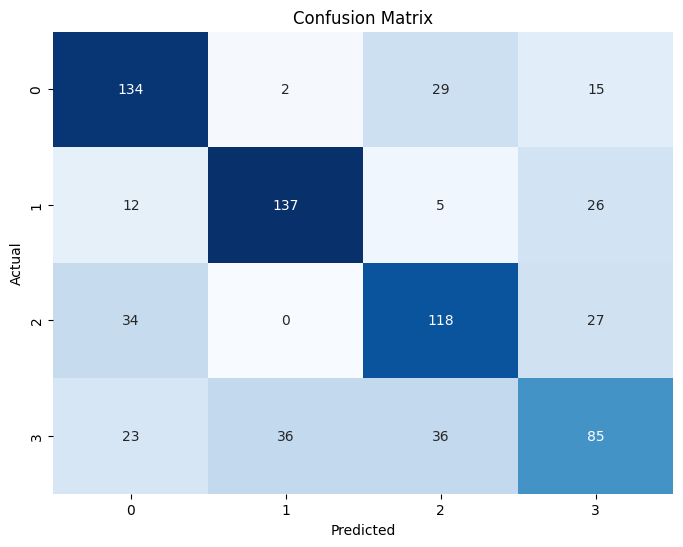

In [285]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score

# Assuming you have already defined classifier, X, and Y_train
estmator = 10
seed = 0
bootstrap_value = False
estimators = [
    ('DecisionTree', BaggingClassifier(estimator= DecisionTreeClassifier(criterion = 'entropy'), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('RandomForest', BaggingClassifier(estimator= RandomForestClassifier(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('LogisticRegression', BaggingClassifier(estimator = LogisticRegression(), n_estimators = estmator, random_state = 0,bootstrap_features=False)),
    ('BGNB', BaggingClassifier(estimator= GaussianNB(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('SVM', BaggingClassifier(estimator= SVC(kernel = 'linear'), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('MNB', BaggingClassifier(estimator= MultinomialNB(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)),
    ('KNN', BaggingClassifier(estimator= KNeighborsClassifier(n_neighbors=5), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value))]

final_estimator = BaggingClassifier(base_estimator= LogisticRegression(), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)

classifier = StackingClassifier(estimators = estimators, final_estimator = final_estimator)
processor = TextProcessor(True, True, True, LemmaTokenizer(), False)
X = processor.trainX(train_corpus)

# Perform cross-validation prediction
ypred = cross_val_predict(classifier, X, Y_train, cv=4)

# Create confusion matrix
conf_matrix = confusion_matrix(Y_train, ypred)

# Calculate accuracy
accuracy = accuracy_score(Y_train, ypred)

# Print and plot the confusion matrix
print(f"Confusion Matrix (Iteration 1):\n{conf_matrix}")
print(f"Accuracy (Iteration 1): {accuracy * 100:.2f}%")

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.unique(Y_train), yticklabels=np.unique(Y_train))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion.png')
plt.show()

In [206]:
#Bagging SVM
kernels = ['linear', 'rbf']
features, tokens = np.linspace(1000, 3000, 5, dtype = int), [None, LemmaTokenizer(), StemTokenizer()]
accuracies_svmbag, count, execution_svmbag = {}, 1, {}
for n in features:
    for token in tokens:
        for kernel in kernels:
            start = time.time()
            label = f'TF - IDF = True | Normalization = False | Kernel = {kernel} | Number of features = {n} | Tokenizer = {token}'
            processor = TextProcessor(True, True, True, token, False, n)
            X = processor.trainX(train_corpus)
            model, validation = BaggingClassifier(estimator= SVC(kernel = kernel), 
                                   n_estimators=estmator, 
                                   random_state=seed,
                                   bootstrap_features=bootstrap_value), CrossValidation(10)
            accuracies_svmbag[label] = validation.validate(model, X, Y_train, False, unique_categories, False)
            end = time.time()
            execution_svmbag[label] = end - start
            print(f'Iteration {count} out of 45 with TF - IDF = True | Normalization = False | Kernel = {kernel} | Number of features = {n} | Tokenizer = {token}')
            print(f'Iteration {count} was {step} s long')
            count += 1

Averrage accuracy of BaggingClassifier(estimator=SVC(kernel='linear'), n_estimators=5,
                  random_state=0) is : 57.3 %
Iteration 1 out of 45 with TF - IDF = True | Normalization = False | Kernel = linear | Number of features = 1000 | Tokenizer = None
Iteration 1 was 12.451283931732178 s long
Averrage accuracy of BaggingClassifier(estimator=SVC(), n_estimators=5, random_state=0) is : 58.41 %
Iteration 2 out of 45 with TF - IDF = True | Normalization = False | Kernel = rbf | Number of features = 1000 | Tokenizer = None
Iteration 2 was 12.451283931732178 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fu', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of BaggingClassifier(estimator=SVC(kernel='linear'), n_estimators=5,
                  random_state=0) is : 59.52 %
Iteration 3 out of 45 with TF - IDF = True | Normalization = False | Kernel = linear | Number of features = 1000 | Tokenizer = Lemma Tokenizer
Iteration 3 was 12.451283931732178 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of BaggingClassifier(estimator=SVC(), n_estimators=5, random_state=0) is : 59.8 %
Iteration 4 out of 45 with TF - IDF = True | Normalization = False | Kernel = rbf | Number of features = 1000 | Tokenizer = Lemma Tokenizer
Iteration 4 was 12.451283931732178 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'aur', 'aurion', 'auron', 'avai', 'avion', 'avon', 'ayon', 'becaus', 'befor', 'could', 'dan', 'doe', 'dure', 'e', 'ell', 'euss', 'eussion', 'eûm', 'fu', 'fuss', 'fussion', 'fûm', 'ha', 'hi', 'mai', 'might', 'must', 'mêm', 'need', 'notr', 'onc', 'onli', 'ourselv', 'pa', 'ser', 'serion', 'seron', 'sha', 'soi', 'somm', 'soyon', 'themselv', 'thi', 'veri', 'vo', 'votr', 'vou', 'wa', 'whi', 'wo', 'would', 'yourselv', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(


Averrage accuracy of BaggingClassifier(estimator=SVC(kernel='linear'), n_estimators=5,
                  random_state=0) is : 57.72 %
Iteration 5 out of 45 with TF - IDF = True | Normalization = False | Kernel = linear | Number of features = 1000 | Tokenizer = Stemming Tokenizer
Iteration 5 was 12.451283931732178 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'aur', 'aurion', 'auron', 'avai', 'avion', 'avon', 'ayon', 'becaus', 'befor', 'could', 'dan', 'doe', 'dure', 'e', 'ell', 'euss', 'eussion', 'eûm', 'fu', 'fuss', 'fussion', 'fûm', 'ha', 'hi', 'mai', 'might', 'must', 'mêm', 'need', 'notr', 'onc', 'onli', 'ourselv', 'pa', 'ser', 'serion', 'seron', 'sha', 'soi', 'somm', 'soyon', 'themselv', 'thi', 'veri', 'vo', 'votr', 'vou', 'wa', 'whi', 'wo', 'would', 'yourselv', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(


Averrage accuracy of BaggingClassifier(estimator=SVC(), n_estimators=5, random_state=0) is : 60.08 %
Iteration 6 out of 45 with TF - IDF = True | Normalization = False | Kernel = rbf | Number of features = 1000 | Tokenizer = Stemming Tokenizer
Iteration 6 was 12.451283931732178 s long
Averrage accuracy of BaggingClassifier(estimator=SVC(kernel='linear'), n_estimators=5,
                  random_state=0) is : 61.75 %
Iteration 7 out of 45 with TF - IDF = True | Normalization = False | Kernel = linear | Number of features = 1500 | Tokenizer = None
Iteration 7 was 12.451283931732178 s long
Averrage accuracy of BaggingClassifier(estimator=SVC(), n_estimators=5, random_state=0) is : 59.52 %
Iteration 8 out of 45 with TF - IDF = True | Normalization = False | Kernel = rbf | Number of features = 1500 | Tokenizer = None
Iteration 8 was 12.451283931732178 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of BaggingClassifier(estimator=SVC(kernel='linear'), n_estimators=5,
                  random_state=0) is : 60.5 %
Iteration 9 out of 45 with TF - IDF = True | Normalization = False | Kernel = linear | Number of features = 1500 | Tokenizer = Lemma Tokenizer
Iteration 9 was 12.451283931732178 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of BaggingClassifier(estimator=SVC(), n_estimators=5, random_state=0) is : 60.63 %
Iteration 10 out of 45 with TF - IDF = True | Normalization = False | Kernel = rbf | Number of features = 1500 | Tokenizer = Lemma Tokenizer
Iteration 10 was 12.451283931732178 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'aur', 'aurion', 'auron', 'avai', 'avion', 'avon', 'ayon', 'becaus', 'befor', 'could', 'dan', 'doe', 'e', 'ell', 'euss', 'eussion', 'eûm', 'fu', 'fuss', 'fussion', 'fûm', 'ha', 'hi', 'mai', 'might', 'must', 'mêm', 'need', 'notr', 'onc', 'onli', 'ourselv', 'pa', 'ser', 'serion', 'seron', 'sha', 'soi', 'somm', 'soyon', 'themselv', 'thi', 'veri', 'vo', 'votr', 'vou', 'wa', 'whi', 'wo', 'would', 'yourselv', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(


Averrage accuracy of BaggingClassifier(estimator=SVC(kernel='linear'), n_estimators=5,
                  random_state=0) is : 60.64 %
Iteration 11 out of 45 with TF - IDF = True | Normalization = False | Kernel = linear | Number of features = 1500 | Tokenizer = Stemming Tokenizer
Iteration 11 was 12.451283931732178 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'aur', 'aurion', 'auron', 'avai', 'avion', 'avon', 'ayon', 'becaus', 'befor', 'could', 'dan', 'doe', 'dure', 'e', 'ell', 'euss', 'eussion', 'eûm', 'fu', 'fuss', 'fussion', 'fûm', 'ha', 'hi', 'mai', 'might', 'must', 'mêm', 'need', 'notr', 'onc', 'onli', 'ourselv', 'pa', 'ser', 'serion', 'seron', 'sha', 'soi', 'somm', 'soyon', 'themselv', 'thi', 'veri', 'vo', 'votr', 'vou', 'wa', 'whi', 'wo', 'would', 'yourselv', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(


Averrage accuracy of BaggingClassifier(estimator=SVC(), n_estimators=5, random_state=0) is : 60.07 %
Iteration 12 out of 45 with TF - IDF = True | Normalization = False | Kernel = rbf | Number of features = 1500 | Tokenizer = Stemming Tokenizer
Iteration 12 was 12.451283931732178 s long
Averrage accuracy of BaggingClassifier(estimator=SVC(kernel='linear'), n_estimators=5,
                  random_state=0) is : 63.27 %
Iteration 13 out of 45 with TF - IDF = True | Normalization = False | Kernel = linear | Number of features = 2000 | Tokenizer = None
Iteration 13 was 12.451283931732178 s long
Averrage accuracy of BaggingClassifier(estimator=SVC(), n_estimators=5, random_state=0) is : 60.49 %
Iteration 14 out of 45 with TF - IDF = True | Normalization = False | Kernel = rbf | Number of features = 2000 | Tokenizer = None
Iteration 14 was 12.451283931732178 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fu', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of BaggingClassifier(estimator=SVC(kernel='linear'), n_estimators=5,
                  random_state=0) is : 61.47 %
Iteration 15 out of 45 with TF - IDF = True | Normalization = False | Kernel = linear | Number of features = 2000 | Tokenizer = Lemma Tokenizer
Iteration 15 was 12.451283931732178 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of BaggingClassifier(estimator=SVC(), n_estimators=5, random_state=0) is : 61.6 %
Iteration 16 out of 45 with TF - IDF = True | Normalization = False | Kernel = rbf | Number of features = 2000 | Tokenizer = Lemma Tokenizer
Iteration 16 was 12.451283931732178 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'aur', 'aurion', 'auron', 'avai', 'avion', 'avon', 'ayon', 'becaus', 'befor', 'could', 'dan', 'doe', 'dure', 'e', 'ell', 'euss', 'eussion', 'eûm', 'fu', 'fuss', 'fussion', 'fûm', 'ha', 'hi', 'mai', 'might', 'must', 'mêm', 'need', 'notr', 'nou', 'onc', 'onli', 'ourselv', 'pa', 'ser', 'serion', 'seron', 'sha', 'soi', 'somm', 'soyon', 'themselv', 'thi', 'veri', 'vo', 'votr', 'vou', 'wa', 'whi', 'wo', 'would', 'yourselv', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(


Averrage accuracy of BaggingClassifier(estimator=SVC(kernel='linear'), n_estimators=5,
                  random_state=0) is : 61.62 %
Iteration 17 out of 45 with TF - IDF = True | Normalization = False | Kernel = linear | Number of features = 2000 | Tokenizer = Stemming Tokenizer
Iteration 17 was 12.451283931732178 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'aur', 'aurion', 'auron', 'avai', 'avion', 'avon', 'ayon', 'becaus', 'befor', 'could', 'dan', 'doe', 'dure', 'e', 'ell', 'euss', 'eussion', 'eûm', 'fu', 'fuss', 'fussion', 'fûm', 'ha', 'hi', 'mai', 'might', 'must', 'mêm', 'need', 'notr', 'nou', 'onc', 'onli', 'ourselv', 'pa', 'ser', 'serion', 'seron', 'sha', 'soi', 'somm', 'soyon', 'themselv', 'thi', 'veri', 'vo', 'votr', 'vou', 'wa', 'whi', 'wo', 'would', 'yourselv', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(


Averrage accuracy of BaggingClassifier(estimator=SVC(), n_estimators=5, random_state=0) is : 61.88 %
Iteration 18 out of 45 with TF - IDF = True | Normalization = False | Kernel = rbf | Number of features = 2000 | Tokenizer = Stemming Tokenizer
Iteration 18 was 12.451283931732178 s long
Averrage accuracy of BaggingClassifier(estimator=SVC(kernel='linear'), n_estimators=5,
                  random_state=0) is : 62.45 %
Iteration 19 out of 45 with TF - IDF = True | Normalization = False | Kernel = linear | Number of features = 2500 | Tokenizer = None
Iteration 19 was 12.451283931732178 s long
Averrage accuracy of BaggingClassifier(estimator=SVC(), n_estimators=5, random_state=0) is : 61.05 %
Iteration 20 out of 45 with TF - IDF = True | Normalization = False | Kernel = rbf | Number of features = 2500 | Tokenizer = None
Iteration 20 was 12.451283931732178 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of BaggingClassifier(estimator=SVC(kernel='linear'), n_estimators=5,
                  random_state=0) is : 63.14 %
Iteration 21 out of 45 with TF - IDF = True | Normalization = False | Kernel = linear | Number of features = 2500 | Tokenizer = Lemma Tokenizer
Iteration 21 was 12.451283931732178 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of BaggingClassifier(estimator=SVC(), n_estimators=5, random_state=0) is : 61.6 %
Iteration 22 out of 45 with TF - IDF = True | Normalization = False | Kernel = rbf | Number of features = 2500 | Tokenizer = Lemma Tokenizer
Iteration 22 was 12.451283931732178 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'aur', 'aurion', 'auron', 'avai', 'avion', 'avon', 'ayon', 'becaus', 'befor', 'could', 'dan', 'doe', 'dure', 'e', 'ell', 'euss', 'eussion', 'eûm', 'fuss', 'fussion', 'fûm', 'ha', 'hi', 'mai', 'might', 'must', 'mêm', 'need', 'notr', 'onc', 'onli', 'ourselv', 'pa', 'ser', 'serion', 'seron', 'sha', 'soi', 'somm', 'soyon', 'themselv', 'thi', 'veri', 'vo', 'votr', 'vou', 'wa', 'whi', 'wo', 'would', 'yourselv', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(


Averrage accuracy of BaggingClassifier(estimator=SVC(kernel='linear'), n_estimators=5,
                  random_state=0) is : 61.47 %
Iteration 23 out of 45 with TF - IDF = True | Normalization = False | Kernel = linear | Number of features = 2500 | Tokenizer = Stemming Tokenizer
Iteration 23 was 12.451283931732178 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'aur', 'aurion', 'auron', 'avai', 'avion', 'avon', 'ayon', 'becaus', 'befor', 'could', 'dan', 'doe', 'dure', 'e', 'ell', 'euss', 'eussion', 'eûm', 'fu', 'fuss', 'fussion', 'fûm', 'ha', 'hi', 'mai', 'might', 'must', 'mêm', 'need', 'notr', 'onc', 'onli', 'ourselv', 'pa', 'ser', 'serion', 'seron', 'sha', 'soi', 'somm', 'soyon', 'themselv', 'thi', 'veri', 'vo', 'votr', 'vou', 'wa', 'whi', 'wo', 'would', 'yourselv', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(


Averrage accuracy of BaggingClassifier(estimator=SVC(), n_estimators=5, random_state=0) is : 61.74 %
Iteration 24 out of 45 with TF - IDF = True | Normalization = False | Kernel = rbf | Number of features = 2500 | Tokenizer = Stemming Tokenizer
Iteration 24 was 12.451283931732178 s long
Averrage accuracy of BaggingClassifier(estimator=SVC(kernel='linear'), n_estimators=5,
                  random_state=0) is : 63.14 %
Iteration 25 out of 45 with TF - IDF = True | Normalization = False | Kernel = linear | Number of features = 3000 | Tokenizer = None
Iteration 25 was 12.451283931732178 s long
Averrage accuracy of BaggingClassifier(estimator=SVC(), n_estimators=5, random_state=0) is : 62.3 %
Iteration 26 out of 45 with TF - IDF = True | Normalization = False | Kernel = rbf | Number of features = 3000 | Tokenizer = None
Iteration 26 was 12.451283931732178 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of BaggingClassifier(estimator=SVC(kernel='linear'), n_estimators=5,
                  random_state=0) is : 63.84 %
Iteration 27 out of 45 with TF - IDF = True | Normalization = False | Kernel = linear | Number of features = 3000 | Tokenizer = Lemma Tokenizer
Iteration 27 was 12.451283931732178 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Averrage accuracy of BaggingClassifier(estimator=SVC(), n_estimators=5, random_state=0) is : 62.16 %
Iteration 28 out of 45 with TF - IDF = True | Normalization = False | Kernel = rbf | Number of features = 3000 | Tokenizer = Lemma Tokenizer
Iteration 28 was 12.451283931732178 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'aur', 'aurion', 'auron', 'avai', 'avion', 'avon', 'ayon', 'becaus', 'befor', 'could', 'dan', 'doe', 'dure', 'e', 'ell', 'euss', 'eussion', 'eûm', 'fu', 'fuss', 'fussion', 'fûm', 'ha', 'hi', 'mai', 'might', 'must', 'mêm', 'need', 'notr', 'onc', 'onli', 'ourselv', 'pa', 'ser', 'serion', 'seron', 'sha', 'soi', 'somm', 'soyon', 'themselv', 'thi', 'veri', 'vo', 'votr', 'vou', 'wa', 'whi', 'wo', 'would', 'yourselv', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(


Averrage accuracy of BaggingClassifier(estimator=SVC(kernel='linear'), n_estimators=5,
                  random_state=0) is : 62.03 %
Iteration 29 out of 45 with TF - IDF = True | Normalization = False | Kernel = linear | Number of features = 3000 | Tokenizer = Stemming Tokenizer
Iteration 29 was 12.451283931732178 s long


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'aur', 'aurion', 'auron', 'avai', 'avion', 'avon', 'ayon', 'becaus', 'befor', 'could', 'dan', 'doe', 'dure', 'e', 'ell', 'euss', 'eussion', 'eûm', 'fuss', 'fussion', 'fûm', 'ha', 'hi', 'mai', 'might', 'must', 'mêm', 'need', 'notr', 'onc', 'onli', 'ourselv', 'pa', 'ser', 'serion', 'seron', 'sha', 'soi', 'somm', 'soyon', 'themselv', 'thi', 'veri', 'vo', 'votr', 'vou', 'wa', 'whi', 'wo', 'would', 'yourselv', 'éti', 'étion', 'ête'] not in stop_words.
  warnings.warn(


Averrage accuracy of BaggingClassifier(estimator=SVC(), n_estimators=5, random_state=0) is : 61.88 %
Iteration 30 out of 45 with TF - IDF = True | Normalization = False | Kernel = rbf | Number of features = 3000 | Tokenizer = Stemming Tokenizer
Iteration 30 was 12.451283931732178 s long


In [233]:
#Bagging SVM with linear kernel
classifier = BaggingClassifier(estimator= SVC(kernel = 'linear'), n_estimators=estmator, random_state=seed,bootstrap_features=bootstrap_value)
processor = TextProcessor(True, True, True, LemmaTokenizer(), False)
X = processor.trainX(train_corpus)
model, validation = classifier, CrossValidation(10)
start = time.time()
accuracy_SVMBAG = validation.validate(model, X, Y_train, True, unique_categories, False)
end = time.time()
print(end- start)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fu', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Iteration 1 of 10 - cross fold on the BaggingClassifier(estimator=SVC(kernel='linear'), random_state=0): Accuracy obtained is 63.38 %
Iteration 2 of 10 - cross fold on the BaggingClassifier(estimator=SVC(kernel='linear'), random_state=0): Accuracy obtained is 62.5 %
Iteration 3 of 10 - cross fold on the BaggingClassifier(estimator=SVC(kernel='linear'), random_state=0): Accuracy obtained is 58.33 %
Iteration 4 of 10 - cross fold on the BaggingClassifier(estimator=SVC(kernel='linear'), random_state=0): Accuracy obtained is 63.89 %
Iteration 5 of 10 - cross fold on the BaggingClassifier(estimator=SVC(kernel='linear'), random_state=0): Accuracy obtained is 73.61 %
Iteration 6 of 10 - cross fold on the BaggingClassifier(estimator=SVC(kernel='linear'), random_state=0): Accuracy obtained is 59.72 %
Iteration 7 of 10 - cross fold on the BaggingClassifier(estimator=SVC(kernel='linear'), random_state=0): Accuracy obtained is 62.5 %
Iteration 8 of 10 - cross fold on the BaggingClassifier(estimato

In [234]:
#Bagging SVM with rbf kernel
classifier = BaggingClassifier(estimator= SVC(kernel = 'rbf'), n_estimators=estmator, random_state=seed,bootstrfeatures=bootstrap_value)
processor = TextProcessor(True, True, True, LemmaTokenizer(), False)
X = processor.trainX(train_corpus)
model, validation = classifier, CrossValidation(10)
start = time.time()
accuracy_SVMBAG_RBF = validation.validate(model, X, Y_train, True, unique_categories, False)
end = time.time()
print(end- start)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aurion', 'avoir', 'could', 'eussion', 'eûme', 'eûte', 'fussion', 'fûme', 'fûte', 'might', 'must', 'need', 'ourselve', 'sha', 'win', 'wo', 'would', 'yourselve', 'éter', 'étion', 'ête', 'être'] not in stop_words.
  warnings.warn(


Iteration 1 of 10 - cross fold on the BaggingClassifier(estimator=SVC(), random_state=0): Accuracy obtained is 54.93 %
Iteration 2 of 10 - cross fold on the BaggingClassifier(estimator=SVC(), random_state=0): Accuracy obtained is 65.28 %
Iteration 3 of 10 - cross fold on the BaggingClassifier(estimator=SVC(), random_state=0): Accuracy obtained is 50.0 %
Iteration 4 of 10 - cross fold on the BaggingClassifier(estimator=SVC(), random_state=0): Accuracy obtained is 58.33 %
Iteration 5 of 10 - cross fold on the BaggingClassifier(estimator=SVC(), random_state=0): Accuracy obtained is 76.39 %
Iteration 6 of 10 - cross fold on the BaggingClassifier(estimator=SVC(), random_state=0): Accuracy obtained is 62.5 %
Iteration 7 of 10 - cross fold on the BaggingClassifier(estimator=SVC(), random_state=0): Accuracy obtained is 59.72 %
Iteration 8 of 10 - cross fold on the BaggingClassifier(estimator=SVC(), random_state=0): Accuracy obtained is 69.44 %
Iteration 9 of 10 - cross fold on the BaggingClass

In [286]:
unique_categories[3]

'Montreal'

In [ ]:
T